In [1]:
import copy
import time, importlib
import h5py
import numpy as np
import os
import pandas as pd
import scipy, scipy.ndimage
import tqdm
import unyt

In [2]:
import kalepy as kale

In [3]:
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects

In [4]:
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines

In [6]:
import galaxy_dive.plot_data.plotting as plotting

In [7]:
import coolingFunction

In [8]:
import trove
import verdict
from py2tex import py2tex

In [9]:
import helpers

In [10]:
%matplotlib inline

# Parameters

In [11]:
pm = dict(
    snum = 600,
    ahf_index = 600,
    
    # Data locations
    tables_dir = '/work2/03057/zhafen/stampede2/CoolingTables/',

    # Constants
    mu = 0.62,
    X = 0.7,
    gamma = 5/3,
    
    # Time analysis parameters
    # If we want to ensure some minimum number of snapshots in the galaxy after accreting
    # (remember to account for the last 10 snapshots with small dt)
    minInd = -1,
    maxInd = 99999999,
#     minInd = 30,
#     maxInd = 54, # Corresponds to 1 Gyr. We don't look at accretion prior.
#     minInd = -1,
    tchange_width = 0.1,
    
    logTenergy = 4.5, # Do we yeet cooling/heating from cool gas when the majority of the gas is hot?
)

In [12]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    script_id = 'nb.9',
    **pm
)

In [13]:
snum = pm['snum']

In [14]:
sim_name = pm['variation']

In [15]:
print( sim_name, pm['global_variation'] )

m11d_md relative_to_accretion


# Load Data

In [16]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['data_dirs']['jug.4'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

In [17]:
print( w.tag )

hothaloacc


In [18]:
ind = pm['ahf_index'] - snum

In [19]:
base_processed_data_dir = pm['config_parser'].get( 'DEFAULT', 'processed_data_dir' )
default_data_fp = os.path.join( base_processed_data_dir, 'summary.hdf5' )
default_data = verdict.Dict.from_hdf5( default_data_fp, create_nonexistent=True )

/home1/03057/zhafen/repos/verdict/verdict.py:1407: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [20]:
data_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_fp, create_nonexistent=True )

In [21]:
x_label = helpers.get_t_tchange_label( pm )

# Analyze

## Find $t_{\rm change}$

In [22]:
if pm['central_indices'] == 'tcools_inds':
    inds = w.calc_tcools_inds(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = pm['choose_first'],
        B = pm['logTcools'],
    )
else:
    calc_fn = getattr( w, 'calc_{}'.format( pm['central_indices'] ) )
    inds = calc_fn(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = pm['choose_first'],
    )

100%|██████████| 10855/10855 [00:01<00:00, 10143.26it/s]


In [23]:
# Get time relative to accretion
age = w.get_data( 'time' )
tchange = age[inds[inds!=-99999]]

In [24]:
minInd = pm['minInd']
maxInd = pm['maxInd']
inds_in_range = (inds>minInd)&(inds<maxInd)

In [25]:
if pm['central_indices'] == 'tcools_inds':
    tacc_inds = w.calc_tacc_inds(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = True,
    )
    w.calc_tacc()
    
    tacc_tcools = ( w.get_data( 'tacc' ) - w.get_data( 'tcools' ) )[inds_in_range]
    median_tacc = np.nanpercentile( tacc_tcools, 50 )

In [26]:
if pm['central_indices'] == 'tacc_inds':
    tcool_inds = w.calc_tcools_inds(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = pm['choose_first'],
        B = pm['logTcools'],
    )
    w.calc_tcools()
    
    tcools_tacc = ( w.get_data( 'tacc' ) - w.get_data( 'tcools' ) )[inds_in_range]
    median_tcools = np.nanpercentile( tcools_tacc, 50 )

100%|██████████| 10855/10855 [00:03<00:00, 2814.25it/s]


## Get Angular Momentum

In [27]:
jmag_raw = w.get_data( 'Lmag' ) / w.get_data('M') * ( unyt.kpc * unyt.km / unyt.s )

/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1181: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.halo_coords = halo_coords_comoving * scale_factor_and_hinv[np.newaxis, :]


In [28]:
tot_momentum_fp = os.path.join( base_processed_data_dir, 'tot_momentums.hdf5' )
tot_ang_momentum = verdict.Dict.from_hdf5( tot_momentum_fp )[pm['variation']]['snum{:03d}'.format( snum )]
tot_ang_momentum_normed = tot_ang_momentum / np.linalg.norm( tot_ang_momentum )

In [29]:
w.total_ang_momentum = tot_ang_momentum_normed

In [30]:
j_raw = w.get_data( 'J' ) * ( unyt.kpc * unyt.km / unyt.s )

In [31]:
jz_raw = np.array([ np.dot( j_raw[:,:,i].transpose(), tot_ang_momentum_normed ) for i in range( w.snums.size ) ]).transpose()

In [32]:
vc_fp = os.path.join( pm['data_dirs']['jug.4'], 'vc_of_tracked_particles.hdf5' )
if os.path.exists( vc_fp ):
    vc_data = verdict.Dict.from_hdf5( vc_fp )
    vc_raw = vc_data[pm['variation']] * unyt.km / unyt.s
else:
    # This can take a while because we need to open all the different profiles (one per snapshot).
    vc_raw = []
    for snum_i in tqdm.tqdm( w.snums ):
        # The profile data for snapshot 0 is often not saved
        if snum_i == 0:
            vc_raw.append( np.full( rs.shape, np.nan ) )
            continue
        rs = w.get_data( 'R' )[:,w.snums[0]-snum_i]
        try:
            vc_i = w.halo_data.get_profile_data( 'vcirc', snum_i, rs )
        except ( KeyError, TypeError, IndexError ) as e:
            vc_i = np.full( rs.shape, np.nan )
        vc_raw.append( vc_i )
    vc_raw = np.array( vc_raw ).transpose() * unyt.km / unyt.s
    
    vc_data = verdict.Dict({
        pm['variation']: vc_raw.value,
    })
    vc_data.to_hdf5( vc_fp )

In [33]:
rvc_raw = np.array( vc_raw * w.get_data( 'R' ) * unyt.kpc )

## Center on $t_{10^5 K}$

In [34]:
def roll_by_inds(arr, inds):
    rows, cols = np.ogrid[:arr.shape[0],:arr.shape[1]]
    cols = (cols + inds[:,np.newaxis])%arr.shape[1]
    return arr[rows,cols]

In [35]:
w.calc_abs_phi( normal_vector=tot_ang_momentum_normed )

/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1626: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if normal_vector == 'total ang momentum':


In [36]:
# Calculate sound speed
gamma = 5./3.
w.data['c_s'] = np.sqrt( gamma * unyt.kb * w.get_data( 'T' ) * unyt.K / unyt.mp / pm['mu'] ).to( 'km/s' ).value

In [37]:
# We'll make a dictionary for rolled data
rolled = {}
keys_to_roll = [
    ( 'Den', unyt.cm**-3 ),
    ( 'T', unyt.K ),
    ( 'Z', unyt.Zsun ),
    ( 'M', unyt.Msun ),
    ( 'R', unyt.kpc ),
    ( 'Rz', unyt.kpc ),
    ( 'PType', 1 ),
    ( 't_{}'.format( pm['central_indices'].split( '_' )[0] ), unyt.Gyr ),
    ( 'AbsPhi', unyt.degree ),
    ( 'c_s', unyt.km / unyt.s ),
    ( 'Vmag', unyt.km / unyt.s ),
]
for i, ( key, unit ) in enumerate( keys_to_roll ):
    print( key )
    rolled[key] = roll_by_inds( w.get_data( key ), inds )[inds_in_range] * unit

Den
T
Z
M
R
Rz
PType
t_tacc
AbsPhi
c_s
Vmag


In [38]:
t_unrolled = w.get_selected_data( 'time', tile_data=True )
t = roll_by_inds( t_unrolled, inds )[inds_in_range]

In [39]:
jmag = roll_by_inds( jmag_raw, inds )[inds_in_range]
rvc = roll_by_inds( rvc_raw, inds )[inds_in_range]
vc = roll_by_inds( vc_raw, inds )[inds_in_range]
jz = roll_by_inds( jz_raw, inds )[inds_in_range] * unyt.kpc * unyt.km / unyt.s
tchange = age[inds[inds_in_range]]

In [40]:
j_rolled = np.array([ roll_by_inds( _, inds )[inds_in_range] for _ in j_raw ])

In [41]:
p_rolled = np.array([ roll_by_inds( _, inds )[inds_in_range] for _ in w.get_data( 'P' ) * unyt.kpc ])

In [42]:
r_gal = np.full( w.n_snaps, np.nan )
r_gal[:w.r_gal.size] = w.r_gal
r_rgal = w.get_data( 'R' ) / r_gal
r_rgal_rolled = roll_by_inds( r_rgal, inds )[inds_in_range]

In [43]:
v_rolled = np.array([ roll_by_inds( _, inds )[inds_in_range] for _ in w.get_data( 'V' ) * unyt.km / unyt.s ])

In [44]:
dt0 = ( np.median( np.gradient( t_unrolled, axis=1)[0,:100 ] ) * unyt.Gyr ).to( 'Myr' )
dnHdt_unrolled = np.gradient( w.get_data( 'Den' )*unyt.cm**-3, axis=1 ) / dt0
dnHdt = roll_by_inds( dnHdt_unrolled[:,:], inds )[inds_in_range]

## Calculate Cooling and Compression

In [45]:
mu, X, gamma = pm['mu'], pm['X'], pm['gamma']

In [46]:
nH = rolled['Den']
T = rolled['T']
r = rolled['R']
K = ( T/nH**(2/3.) * unyt.kb ).to('keV*cm**2')
P = ( (mu * X)**-1 * nH * unyt.kb ).to( 'erg/K/cm**3' )* T
rho = nH * unyt.mp / X

In [47]:
LAMBDA = coolingFunction.LambdaFunc(0, pm['tables_dir'], 0.2485)(
    rolled['T'].value,
    rolled['Den'].value,
    rolled['Z'].value,
) * unyt.erg * unyt.cm**3 / unyt.s #using z=0 is an approximation
rad_per_unit_volume = nH**2*LAMBDA 
rad_per_unit_mass = ( rad_per_unit_volume / rho ).to( 'erg/s/g' )
rad = rad_per_unit_mass * rolled['M']

In [48]:
compress_per_unit_volume = ( P*dnHdt / nH ).to( 'erg/s/cm**3' )
compress_per_unit_mass = ( compress_per_unit_volume  / rho ).to( 'erg/s/g' )

## Calculate Gas Temperature and Density
Need to do this separately because we don't want stars messing up the temp

In [49]:
med_gas_temp = []
low_gas_temp = []
high_gas_temp = []
inds2 = np.arange(-50,100)
for i in tqdm.tqdm( inds2 ):
    gas_temp = rolled['T'][:,i][rolled['PType'][:,i]==0]
    med_gas_temp.append( np.nanmedian( gas_temp ) )
    low_gas_temp.append( np.nanpercentile( gas_temp, 16. ) )
    high_gas_temp.append( np.nanpercentile( gas_temp, 84. ) )
med_gas_temp = np.array( med_gas_temp )
low_gas_temp = np.array( low_gas_temp )
high_gas_temp = np.array( high_gas_temp )

100%|██████████| 150/150 [00:00<00:00, 1490.41it/s]


In [50]:
med_gas_den = []
low_gas_den = []
high_gas_den = []
frac_ism = []
frac_sfing = []
frac_dense = []
frac_dense_or_star = []
for i in tqdm.tqdm( inds2 ):
    gas_den = rolled['Den'][:,i][rolled['PType'][:,i]==0]
    med_gas_den.append( np.nanmedian( gas_den ) )
    low_gas_den.append( np.nanpercentile( gas_den, 16 ) )
    high_gas_den.append( np.nanpercentile( gas_den, 84 ) )
    frac_ism.append( ( gas_den > 0.173 ).sum() / gas_den.size )
    frac_dense.append( ( gas_den > 10. ).sum() / gas_den.size )
    frac_sfing.append( ( gas_den > 100. ).sum() / gas_den.size )
    frac_dense_or_star.append( ( ( gas_den > 10. ).sum() + ( rolled['PType'][:,i]==4 ).sum() ) / rolled['PType'][:,i].size )
med_gas_den = np.array( med_gas_den )
low_gas_den = np.array( low_gas_den )
high_gas_den = np.array( high_gas_den )
frac_ism = np.array( frac_ism )
frac_sfing = np.array( frac_sfing )
frac_dense = np.array( frac_dense )
frac_dense_or_star = np.array( frac_dense_or_star )

100%|██████████| 150/150 [00:00<00:00, 1044.56it/s]


## Bin into bins of $t_{10^5 K}$ with fixed width and sum heating and cooling

In [51]:
# Bins. Note that we offset by the width of the last snapshot to avoid the most obvious edge cases
tchange_bins = np.arange( age.max() + 0.5*(age[0] - age[1]), 11., -pm['tchange_width'] )

In [52]:
time = inds2*dt0

In [53]:
# This is essential. If not removing outliers we get very weird results when calculating the mean.
def remove_outliers( a, q=None, T=None, in_bin=None, logTcut=None, qT=None, require_is_mostly_hot=True ):
    
    # Setup
    result = copy.copy( a )
    if T is not None:
        validT = T[in_bin]
    
    # Apply various filters
    if q is not None:
        outlier = np.nanpercentile( np.abs( a ), q )
        result[np.abs(a)>outlier] = outlier
    if logTcut is not None:
        is_outlier = np.log10(validT) < logTcut
        if require_is_mostly_hot:
            is_mostly_hot = np.nanmedian( np.log10( T ), axis=0 ) > logTcut
            valid_is_mostly_hot = np.tile( is_mostly_hot, ( rolled['T'].shape[0], 1 ) )[in_bin]
            is_outlier = is_outlier & valid_is_mostly_hot
        result[is_outlier] = np.nan
    if qT is not None:
        outlierT = np.nanpercentile( validT, qT )
        result[validT<outlierT] = np.nan
        
    # Handle nans
    result[np.isnan(np.log10(result))] = 1e-10
    
    return result

In [54]:
binned_rad_per_unit_mass = []
binned_compress_per_unit_mass = []
mean_j = []
mean_rad_per_unit_mass = []
mean_compress_per_unit_mass = []
n_too_few = 0
for i, start in enumerate( tqdm.tqdm( tchange_bins[:-1] ) ):
    
    end = tchange_bins[i+1]
    in_bin = ( tchange < start ) & ( tchange > end )
    
    binned_rad_per_unit_mass.append( rad_per_unit_mass[in_bin] )
    binned_compress_per_unit_mass.append( compress_per_unit_mass[in_bin] )
    
    # Don't try to sum tchange bins with too few particles
    if in_bin.sum() < tchange.size * 0.05:
        mean_rad_per_unit_mass.append( np.full( (600,), np.nan ) )
        mean_compress_per_unit_mass.append( np.full( (600,), np.nan ) )
        mean_j.append( np.full( (3, 600,), np.nan ) )
        n_too_few += 1
        continue
        
    # Avoid edge cases affecting the results
    rad = remove_outliers(
        rad_per_unit_mass[in_bin],
        q = pm['energy_outlier_percentile'],
        T = rolled['T'],
        in_bin = in_bin,
        logTcut = pm['logTenergy'],
    )
    compress = remove_outliers(
        compress_per_unit_mass[in_bin],
        q = pm['energy_outlier_percentile'],
        T = rolled['T'],
        in_bin = in_bin,
        logTcut = pm['logTenergy'],
    )
    
    mean_j_i =  np.array([ np.nanmean( _[in_bin], axis=0 ) for _ in j_rolled ])
        
    mean_rad_per_unit_mass.append( np.nanmean( rad, axis=0 ) )
    mean_compress_per_unit_mass.append( np.nanmean( compress, axis=0 ) )
    mean_j.append( mean_j_i )

  0%|          | 0/27 [00:00<?, ?it/s]/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/unyt/array.py:1674: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
100%|██████████| 27/27 [00:01<00:00, 13.56it/s]


In [55]:
n_bin = np.array([ _.shape[0] for _ in binned_rad_per_unit_mass ])

Text(0, 0.5, 'specific heating/cooling rate\n[erg/s/g]')

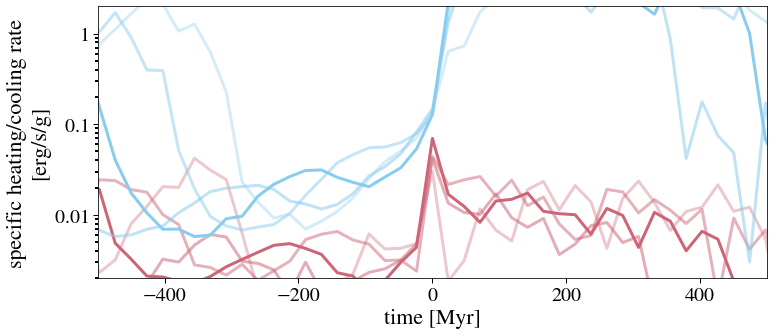

In [56]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

for j, mean_rad_per_unit_mass_j in enumerate( mean_rad_per_unit_mass ):
    ax.plot(
        time,
        mean_compress_per_unit_mass[j][inds2],
        color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[1],
        linewidth = 3,
        alpha = n_bin[j]/n_bin.max(),
        zorder = -1,
    )
    ax.plot(
        time,
        mean_rad_per_unit_mass_j[inds2],
        color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[0],
        linewidth = 3,
        alpha = n_bin[j]/n_bin.max(),
    )
    
ax.set_yscale( 'log' )
ax.set_xlim( -500, 500 )
ax.set_ylim( 2e-3, 10**0.3 )

ax.set_xlabel( 'time [Myr]', fontsize=22 )
ax.set_ylabel( 'specific heating/cooling rate\n[erg/s/g]', fontsize=22 )

## Vector Quantity Manipulation

In [57]:
mean_jz = np.array([ np.dot( _.transpose(), tot_ang_momentum_normed ) for _ in mean_j ])
mean_jmag = np.array([ np.linalg.norm( _, axis=0 ) for _ in mean_j ])
mean_jz_jmag = mean_jz / mean_jmag

<ipython-input-57-faaa942281a4>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_jz = np.array([ np.dot( _.transpose(), tot_ang_momentum_normed ) for _ in mean_j ])
<ipython-input-57-faaa942281a4>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_jmag = np.array([ np.linalg.norm( _, axis=0 ) for _ in mean_j ])


In [58]:
mean_j_all = np.array([ np.nanmean( _, axis=0 ) for _ in j_rolled ])
mean_jz_all = np.dot( mean_j_all.transpose(), tot_ang_momentum_normed )

In [59]:
is_nan = np.array([ np.isnan( j_rolled[:,:,i] ).sum( axis=0 ) for i in range( j_rolled.shape[-1] ) ])
j_count = j_rolled.shape[1] - np.sum( is_nan, axis=1 )

In [60]:
total_j = np.array([ np.nansum( _, axis=0 ) for _ in j_rolled ])
total_jz = np.dot( total_j.transpose(), tot_ang_momentum_normed )
total_jmag = np.linalg.norm( total_j, axis=0 )
total_jz_jmag = total_jz / total_jmag
total_jz /= j_count
total_jmag /= j_count
circulation = total_jmag / np.nansum( jmag, axis=0 )

In [61]:
vz = np.array([ np.dot( _, tot_ang_momentum_normed ) for _ in v_rolled.transpose() ]).transpose()
z = np.array([ np.dot( _, tot_ang_momentum_normed ) for _ in p_rolled.transpose() ]).transpose()

In [62]:
vr = []
vz = []
vzabs = []
vphi = []
jr = []
jz = []
jphi = []
v_rolled_t = v_rolled.transpose()
j_rolled_t = j_rolled.transpose()
for i, p_snum in enumerate( tqdm.tqdm( p_rolled.transpose(), ) ):
    
    # Radial
    r_snum = np.linalg.norm( p_snum, axis=1 )
    r_hat = ( p_snum / r_snum[:,np.newaxis] )
    vr_snum = ( r_hat * v_rolled_t[i] ).sum( axis=1 )
    jr_snum = ( r_hat * j_rolled_t[i] ).sum( axis=1 )
    vr.append( vr_snum )
    jr.append( jr_snum )
    
    # Vertical
    z_snum = np.dot( p_snum, tot_ang_momentum_normed )
    vz_snum = np.dot( v_rolled_t[i], tot_ang_momentum_normed )
    jz_snum = np.dot( j_rolled_t[i], tot_ang_momentum_normed )
    vz.append( vz_snum )
    jz.append( jz_snum )
    vzabs.append( vz_snum * np.sign( z_snum ) )
    
    # Tangential
    z_term = ( z_snum * tot_ang_momentum_normed[:,np.newaxis] ).transpose()
    rperp = p_snum - z_term
    rperp_mag = np.linalg.norm( rperp, axis=1 )
    rperp_hat = rperp / rperp_mag[:,np.newaxis]
    phihat_snum = np.cross( tot_ang_momentum_normed, rperp_hat )
    vphi_snum = np.array([ np.dot( _, phihat_snum[k], ) for k, _ in enumerate( v_rolled_t[i] ) ])
    jphi_snum = np.array([ np.dot( _, phihat_snum[k], ) for k, _ in enumerate( j_rolled_t[i] ) ])
    vphi.append( vphi_snum )
    jphi.append( jphi_snum )
    
vr = np.array( vr ).transpose()
vz = np.array( vz ).transpose()
vzabs = np.array( vzabs ).transpose()
vphi = np.array( vphi ).transpose()
jr = np.array( jr ).transpose()
jz = np.array( jz ).transpose()
jphi = np.array( jphi ).transpose()

100%|██████████| 601/601 [00:14<00:00, 41.31it/s]


## Torque
I.e. change in angular momentum

In [63]:
# Change in components
delta_jz =  np.gradient( jz, axis=1 )
delta_jmag = np.gradient( jmag, axis=1 )
jperp = np.sqrt( jmag**2. - ( jz * jmag.units )**2. )
delta_jperp = np.gradient( jperp, axis=1 )

In [64]:
# Components of gradient vector
dj = np.array([ np.gradient( _, axis=1 ) for _ in j_rolled ]) / np.abs( dt0 ).value
djmag = np.linalg.norm( dj, axis=0 )
djz = np.array([ np.dot( _, tot_ang_momentum_normed ) for _ in dj.transpose() ]).transpose()
djperp = np.sqrt( djmag**2. - djz**2. )

In [65]:
# Other components
djr = []
djz = []
djphi = []
v_rolled_t = v_rolled.transpose()
j_rolled_t = j_rolled.transpose()
dj_t = dj.transpose()
for i, p_snum in enumerate( tqdm.tqdm( p_rolled.transpose(), ) ):
    
    # Radial
    r_snum = np.linalg.norm( p_snum, axis=1 )
    r_hat = ( p_snum / r_snum[:,np.newaxis] )
    djr_snum = ( r_hat * dj_t[i] ).sum( axis=1 )
    djr.append( djr_snum )
    
    # Vertical
    z_snum = np.dot( p_snum, tot_ang_momentum_normed )
    djz_snum = np.dot( dj_t[i], tot_ang_momentum_normed )
    djz.append( djz_snum )
    
    # Tangential
    z_term = ( z_snum * tot_ang_momentum_normed[:,np.newaxis] ).transpose()
    rperp = p_snum - z_term
    rperp_mag = np.linalg.norm( rperp, axis=1 )
    rperp_hat = rperp / rperp_mag[:,np.newaxis]
    phihat_snum = np.cross( tot_ang_momentum_normed, rperp_hat )
    djphi_snum = np.array([ np.dot( _, phihat_snum[k], ) for k, _ in enumerate( dj_t[i] ) ])
    djphi.append( djphi_snum )
    
djr = np.array( djr ).transpose()
djz = np.array( djz ).transpose()
djphi = np.array( djphi ).transpose()

100%|██████████| 601/601 [00:06<00:00, 94.11it/s]


## Volume Filling Factor

In [66]:
vol = rolled['M'].to( 'Msun' ) / ( rolled['Den'] * unyt.mp ).to( 'Msun/kpc**3' )

In [67]:
r_centers = []
r_hists = []
vol_fill = []
for i in tqdm.tqdm( range( r.shape[1] ) ):

    # Bin in r
    r_sl = r[:,i]
    r_bins = np.linspace( np.nanmin( r_sl ), np.nanmax( r_sl ), 16 )
    hist, _ = np.histogram(
        r[:,i],
        r_bins,
    )
    r_centers.append( r_bins[:-1] + 0.5 * (r_bins[1] - r_bins[0] ) )
    r_hists.append( hist )

    # Compute volume-filling-fraction at each radius
    vol_sl = []
    vol_max = []
    for j, r_in in enumerate( r_bins[:-1] ):
        r_out = r_bins[j+1]
        in_bin = ( r_in < r_sl ) & ( r_sl < r_out )
        vol_sl.append( vol[:,i][in_bin].sum() )
        vol_max.append( 4./3.*np.pi * ( r_out**3. - r_in**3. ) )
    vol_sl = np.array( vol_sl )
    vol_max = np.array( vol_max )
    vol_fill.append( vol_sl / vol_max )

100%|██████████| 601/601 [00:02<00:00, 289.70it/s]


In [68]:
r_centers = np.array( r_centers )
r_hists = np.array( r_hists )
vol_fill = np.array( vol_fill )

In [69]:
normed_fraction = r_hists / np.nanmax( r_hists, axis=1 )[:,np.newaxis]

In [70]:
# Setup time bins
t_centers = w.get_data( 'time' )
t_bins = np.full( t_centers.size+1, 0. )
t_bins[:-1] = t_centers - 0.001

In [71]:
# Setup r bins
r_bins = np.linspace( 0., 50., 64 )

In [72]:
# Create volume weights
vol = w.get_data( 'M' ) * unyt.Msun / ( w.get_data( 'Den' ) * unyt.mp / unyt.cm**3 ).to( 'Msun/kpc**3' )
vol[np.isnan(vol)] = 0.

In [73]:
vol_in_shell = []
for i in tqdm.tqdm( range( vol.shape[1] ) ):

    # Bin in r
    hist, _ = np.histogram(
        w.get_data( 'R' )[:,i],
        r_bins,
        weights = vol[:,i],
        density = False,
    )
    vol_in_shell.append( hist )
vol_in_shell = np.array( vol_in_shell )

100%|██████████| 601/601 [00:00<00:00, 1152.31it/s]


In [74]:
vol_shell = 4./3.*np.pi * np.array([ r_bins[1:]**3. - r_bins[:-1]**3. ])

In [75]:
vol_fill = vol_in_shell / vol_shell

(12.569048881530762, 13.569048881530762)

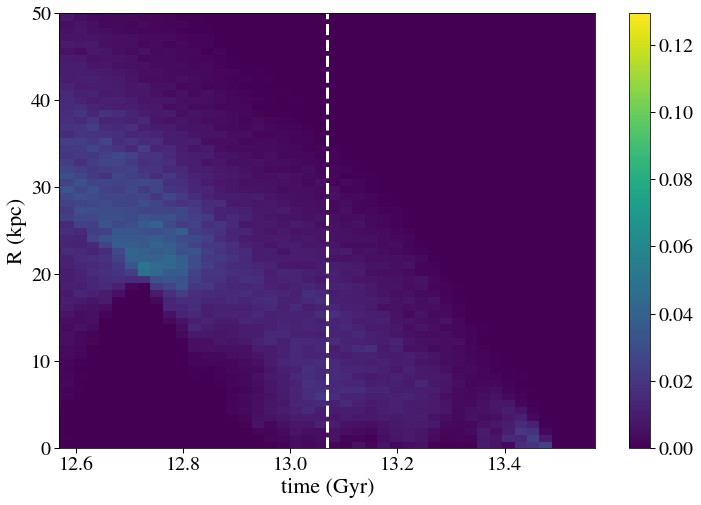

In [76]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

mesh = ax.pcolormesh(
    t_bins,
    r_bins,
    vol_fill.transpose(),
)
cbar = plt.colorbar( mesh )

tchange_med = np.median( tchange )
ax.axvline(
    tchange_med,
    color = 'w',
    linewidth = 3,
    linestyle = '--',
)

ax.set_xlabel( 'time (Gyr)', fontsize=22 )
ax.set_ylabel( 'R (kpc)', fontsize=22 )
ax.set_xlim( tchange_med - 0.5, tchange_med + 0.5 )

/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/work2/03057/zhafen/stampede2/

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

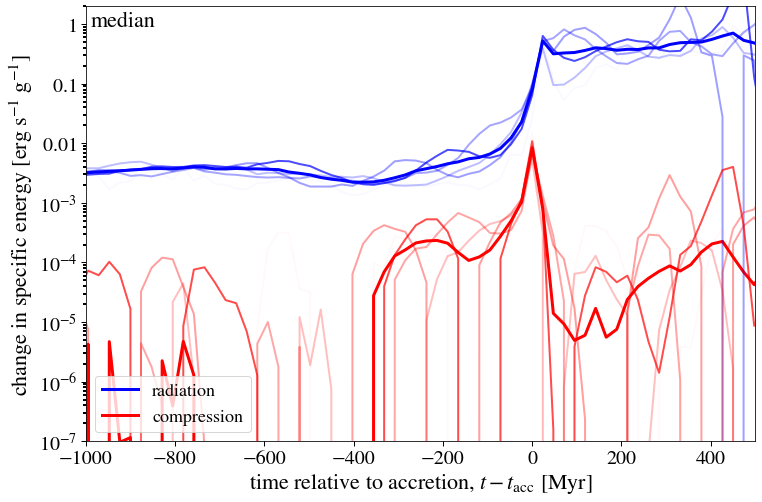

In [77]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

# Total median
ax.plot(
    time,
    np.nanmedian( rad_per_unit_mass, axis=0 )[inds2],
    color = 'b',
    linewidth = 3,
    label = 'radiation',
)
ax.plot(
    time,
    np.nanmedian( compress_per_unit_mass, axis=0 )[inds2],
    color = 'r',
    linewidth = 3,
    label = 'compression',
)

# In bins
for i, rad in enumerate( binned_rad_per_unit_mass ):
    ax.plot(
        time,
        np.nanmedian( rad, axis=0 )[inds2],
        color = 'b',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    ax.plot(
        time,
        np.nanmedian( binned_compress_per_unit_mass[i], axis=0 )[inds2],
        color = 'r',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    
ax.annotate(
    text ='median',
    xy = ( 0, 1 ),
    xytext = ( 5, -5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 22,
    va = 'top',
    ha = 'left',
)

ax.set_yscale( 'log' )
ax.set_xlim( -1000, 500 )
ax.set_ylim( 1e-7, 2 )
ax.legend( prop={'size': 18}, loc='lower left', )

ax.set_ylabel( r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]', fontsize=22 )
ax.set_xlabel( x_label, fontsize=22 )

# pl.savefig( figDir+'rad_vs_compress_median.pdf' )

## Summary Figure

### Figure Label

### Time Offset
We're going to offset the time visually s.t. the median crosses T=1e4.5 K right at t=0 (in the case of $t_{\rm change} = t_{\rm T=10^5 K}$
The reason it doesn't do that automatically is because of limited time resolution.

In [78]:
# Calculate offset
if pm['central_indices'] == 'tcools_inds':
    allowed_err = 1. * unyt.Myr
    close_to_tcools = ( time > -allowed_err ) & ( time < np.abs( dt0 ) + allowed_err )
    time_offset = scipy.interpolate.interp1d( np.log10( med_gas_temp[close_to_tcools] ), time[close_to_tcools] )( pm['logTcools'] ) * unyt.Myr
# If the offset fails because we're not use tcools
else:
    time_offset = 0

In [79]:
time -= time_offset

In [80]:
# Store for later use.
if 'tchange_offset' not in data:
    data['tchange_offset'] = {}
data['tchange_offset'][pm['variation']] = time_offset
data.to_hdf5( data_fp, handle_jagged_arrs='row datasets' )

100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


#### Accretion vs cooling time offset

In [81]:
if pm['central_indices'] == 'tcools_inds':
    delta_t = ( w.get_data( 'tacc' ) - w.get_data( 'tcools' ) )[inds_in_range]
    med_delta_t = np.nanpercentile( delta_t, 50 )

### Appendix Version
Has more stuff on it, a bit messy.

In [91]:
colormap = palettable.cartocolors.qualitative.Safe_10.mpl_colors

#### Setup

In [92]:
nrows = 4
ncols = 2
fig = plt.figure( figsize=(12 * ncols, 4 * nrows), facecolor='w' )

gs = gridspec.GridSpec( ncols=ncols, nrows=nrows, )
gs.update( wspace=0.50, )
leftlabelpad = 65.
rightlabelpad = 65.

def labelpad( i ):
    if i - (i//ncols) * ncols:
        return rightlabelpad
    else:
        return leftlabelpad

errt = 30./2.

rotation = 45.

panel_letters = 'ABCDEFGHIJK'

i = 0

<Figure size 1728x1152 with 0 Axes>

In [93]:
def get_ax( i ):

    j = i // ncols
    return fig.add_subplot( gs[j,i - j * ncols] )

#### Temperature

In [94]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Plot T
ax.plot(
    time,
    med_gas_temp,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_temp,
    high_gas_temp,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.axhline(
    10.**pm['logTcools'],
    color = pm['background_linecolor'],
    linewidth = 1,
)

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)
if pm['central_indices'] == 'tcools_inds':
    ax.axvline(
        median_tacc * 1e3,
        color = pm['background_linecolor'],
        linewidth = 1,
    )
    ax.annotate(
        text = r'$\langle t_{\rm acc} \rangle$',
        xy = ( median_tacc * 1e3, 1. ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
        xytext = ( -5, -5 ),
        textcoords = 'offset points',
        fontsize = 22,
        color = pm['background_linecolor'],
        ha = 'right',
        va = 'top',
    )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0.95*low_gas_temp.min(), 1.05*high_gas_temp.max() )
ax.set_ylabel(
    'T [K]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.set_yscale( 'log' )
ax.set_yticks( [1e2, 1e3, 1e4, 1e5, 1e6 ] )
ax.set_yticklabels( [ '100', '1000', r'$10^4$', r'$10^5$', r'$10^6$'] )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Distance

##### Radius

In [95]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

r_med = np.nanpercentile( r, 50., axis=0 )
ax.plot(
    time,
    r_med[inds2],
    color = colormap[3],
    linewidth = 3,
)
r_low = np.nanpercentile( r, 16, axis=0 )[inds2]
r_high = np.nanpercentile( r, 84., axis=0 )[inds2]
ax.fill_between(
    time,
    r_low,
    r_high,
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, r_med[inds2] )( -500 )
text = ax.annotate(
    text =r'$r$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
#     color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# ax.fill_betweenx(
#     [ 0., 1. ],
#     [ -errt, ]*2,
#     [ errt, ]*2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
#     facecolor = 'none',
#     edgecolor = pm['background_linecolor'],
#     linewidth = 1.0,
#     hatch = '/',
# )

# ax.axhline(
#     w.r_gal[0],
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )
# ax.annotate(
# #     text =r'$4 r_\star(z=0)$',
#     text =r'$r_{\rm gal}$',
# #     text ='disk radius',
#     xy = ( 0, w.r_gal[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
#     color = pm['background_linecolor'],
#     fontweight = 'bold',
# )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, r_high[(time>-500.)&(time<500.)].max() )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
# ax.set_ylabel(
#     'r [kpc]',
#     fontsize=22,
#     rotation=rotation,
#     va='center',
#     ha='center',
#     labelpad = labelpad( i ),
# )
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
# ax_r.set_ylabel( r'r/$r_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
# i += 1


(0.0, 0.2346713661013343)

##### Vertical Height

In [96]:
# ax = get_ax( i )

# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

z_abs = np.abs( z )

z_med = np.nanmedian( z_abs, axis=0 )
ax.plot(
    time,
    z_med[inds2],
    color = colormap[4],
    linewidth = 3,
)
z_low = np.nanpercentile( z_abs, 16, axis=0 )
z_high = np.nanpercentile( z_abs, 84., axis=0 )
ax.fill_between(
    time,
    z_low[inds2],
    z_high[inds2],
    color = colormap[4],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, z_med[inds2] )( -450 )
text = ax.annotate(
    text =r'$\vert z \vert$',
    xy = ( -450, y_annot ),
    xycoords = ax.transData,
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[4],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

ax.axhline(
    w.r_gal[0],
    color = pm['background_linecolor'],
    linewidth = 1,
)
text = ax.annotate(
    text =r'$r_{\rm gal}$',
    xy = ( 1, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'right',
    va = 'bottom',
    color = pm['background_linecolor'],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# ax.set_xlim( -500, 500 )
# ax.set_ylim( 0, 1.5 * w.r_gal[0] )
# # ax.set_yscale( 'log' )
# # ax.set_ylim( 5, 100 )
# ax.set_ylabel(
#     r'$\mid z \mid$ [kpc]',
#     fontsize=22,
#     rotation=rotation,
#     va='center',
#     ha='center',
#     labelpad = labelpad( i ),
# )
    
# ax_r = ax.twinx()
# ax_ylim = ax.get_ylim()
# ax_r.set_ylim( np.array( ax_ylim ) / w.r_gal[ind] )
# ax_r.set_ylabel( r'$\mid z \mid /r_{\rm gal}(z=0)$', fontsize=22 )

ax.set_ylabel(
    'distance\n[kpc]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax_r.set_ylabel( r'distance [$r_{\rm vir}(z=0)]$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1

#### Velocity Components

In [97]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Vr
vrabs = np.abs( vr )
vr_med = np.nanpercentile( vrabs, 50., axis=0 )
ax.plot(
    time,
    vr_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[3],
    linewidth = 5,
)
vr_low = np.nanpercentile( vrabs, 16, axis=0 )
vr_high = np.nanpercentile( vrabs, 84., axis=0 )
ax.fill_between(
    time,
    vr_low[inds2],
    vr_high[inds2],
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vr_med[inds2] )( -200 )
text = ax.annotate(
    text =r'$\vert v_r \vert$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = colormap[3],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vz
vzabs = np.abs( vz )
vz_med = np.nanpercentile( vzabs, 50., axis=0 )
ax.plot(
    time,
    vz_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[5],
    linewidth = 5,
)
vz_low = np.nanpercentile( vzabs, 16, axis=0 )
vz_high = np.nanpercentile( vzabs, 84., axis=0 )
ax.fill_between(
    time,
    vz_low[inds2],
    vz_high[inds2],
    color = colormap[5],
    alpha = 0.1,
)
y_offset = -5
va = 'top'
y_annot = scipy.interpolate.interp1d( time, vz_med[inds2] )( -300 )
text = ax.annotate(
    text =r'$\vert v_z \vert$',
    xy = ( -300, y_annot ),
    xycoords = 'data',
    xytext = ( 0, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[5],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vphi
vphiabs = np.abs( vphi )
vphi_med = np.nanpercentile( vphiabs, 50., axis=0 )
ax.plot(
    time,
    vphi_med[inds2],
    color = colormap[4],
    linewidth = 5,
)
vphi_low = np.nanpercentile( vphiabs, 16, axis=0 )
vphi_high = np.nanpercentile( vphiabs, 84., axis=0 )
ax.fill_between(
    time,
    vphi_low[inds2],
    vphi_high[inds2],
    color = colormap[4],
    alpha = 0.1,
)
if sim_name == 'm11d_md':
    y_offset = -5
    va = 'top'
else:
    y_offset = 5
    va = 'bottom'
y_annot = scipy.interpolate.interp1d( time, vphi_med[inds2] )( -400 )
text = ax.annotate(
    text =r'$v_\phi$',
    xy = ( -400, y_annot ),
    xycoords = 'data',
    xytext = ( 0, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[4],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vc
vcabs = np.abs( vc )
vc_med = np.nanpercentile( vcabs, 50., axis=0 )
ax.plot(
    time,
    vc_med[inds2],
    color = '.1',
    linewidth = 2,
    linestyle = '-.',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( vcabs, 16, axis=0 )[inds2],
#     np.nanpercentile( vcabs, 84., axis=0 )[inds2],
#     color = colormap[2],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, vc_med[inds2] )( -200 )
text = ax.annotate(
    text =r'$v_c(r)$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)

# c_hot = 100. * np.sqrt( w.t_vir[snum] / 4.5e5 )
# ax.axhline(
#     c_hot,
#     color = pm['background_linecolor'],
#     linewidth = 1.,
# )
# ax.axhline(
#     -c_hot,
#     color = pm['background_linecolor'],
#     linewidth = 1.,
# )
# ax.annotate(
#     text = r'$c_s(T_{\rm vir})$',
#     xy = ( 300, c_hot ),
#     xycoords = 'data',
#     xytext = ( 0, 5 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'left',
#     fontsize = 22,
#     color = pm['background_linecolor'],
# )

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_yticks( np.arange( -1000, 1000, 50 ) )

ax.set_xlim( -500, 500 )
# ax.set_ylim( vr_low[inds2][time>-500.].min(), 1.05*vc_med[inds2][time<500.].max() )
ymax = np.max([ 1.05*vphi_high[inds2][time<500.].max(), 1.05*vc_med[inds2][time<500.].max() ])
ax.set_ylim( 0., 1.05*vc_med[inds2][time<500.].max() )
ax.set_ylabel(
    'velocity\n[km/s]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

In [98]:
# Mach Number

# ax = get_ax( i )

# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# valid = rolled['PType'] == 0
# # valid = ( rolled['T'] > np.nanmedian( rolled['T'][inds2] ) ) & valid
# def calc_mach( v ):
    
#     m = v / c_hot
# #     m = v / rolled['c_s']
#     med = []
#     low = []
#     high = []
#     for i, valid_i in enumerate( tqdm.tqdm( valid.transpose() ) ):
#         med.append( np.nanmedian( m[:,i][valid_i] ) )
#         low.append( np.nanpercentile( m[:,i][valid_i], 16 ) )
#         high.append( np.nanpercentile( m[:,i][valid_i], 84 ) )
        
#     return np.array( med )[inds2], np.array( low )[inds2], np.array( high )[inds2]

# # # Mach
# # mach_med, mach_low, mach_high = calc_mach( rolled['Vmag'] )
# # ax.plot(
# #     time,
# #     mach_med,
# #     color = 'k',
# #     linewidth = 5,
# # )
# # ax.fill_between(
# #     time,
# #     mach_low,
# #     mach_high,
# #     color = 'k',
# #     alpha = 0.1,
# # )
# # y_annot = scipy.interpolate.interp1d( time, mach_med )( -200 )
# # text = ax.annotate(
# #     text =r'$\mathcal{M}$',
# #     xy = ( -200, y_annot ),
# #     xycoords = 'data',
# #     xytext = ( 0, 5 ),
# #     textcoords = 'offset points',
# #     fontsize = 24,
# #     ha = 'left',
# #     va = 'bottom',
# #     color = 'k',
# #     fontweight = 'bold',
# # )
# # text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # Mach_r
# machr_med, machr_low, machr_high = calc_mach( vr )
# ax.plot(
#     time,
#     machr_med,
#     color = colormap[3],
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     machr_low,
#     machr_high,
#     color = colormap[3],
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, machr_med )( -200 )
# text = ax.annotate(
#     text =r'$\mathcal{M}_r$',
#     xy = ( -200, y_annot ),
#     xycoords = 'data',
#     xytext = ( 0, -5 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'top',
#     color = colormap[3],
#     fontweight = 'bold',
# )
# text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # # Machz
# # machz_med, machz_low, machz_high = calc_mach( vz )
# # ax.plot(
# #     time,
# #     machz_med,
# #     color = colormap[5],
# #     linewidth = 5,
# # )
# # ax.fill_between(
# #     time,
# #     machz_low,
# #     machz_high,
# #     color = colormap[5],
# #     alpha = 0.1,
# # )
# # if sim_name == 'm12b_md':
# #     y_offset = 5
# #     va = 'bottom'
# # else:
# #     y_offset = 5
# #     va = 'bottom'
# # y_annot = scipy.interpolate.interp1d( time, machz_med )( -300 )
# # text = ax.annotate(
# #     text =r'$\mathcal{M}_{\vert z \vert}$',
# #     xy = ( -300, y_annot ),
# #     xycoords = 'data',
# #     xytext = ( 0, y_offset ),
# #     textcoords = 'offset points',
# #     fontsize = 24,
# #     ha = 'left',
# #     va = va,
# #     color = colormap[5],
# #     fontweight = 'bold',
# # )
# # text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # Vphi
# machphi_med, machphi_low, machphi_high = calc_mach( vphi )
# ax.plot(
#     time,
#     machphi_med,
#     color = colormap[4],
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     machphi_low,
#     machphi_high,
#     color = colormap[4],
#     alpha = 0.1,
# )
# if sim_name == 'm12b_md':
#     y_offset = 5
#     va = 'bottom'
# else:
#     y_offset = 5
#     va = 'bottom'
# y_annot = scipy.interpolate.interp1d( time, machphi_med )( -400 )
# text = ax.annotate(
#     text =r'$\mathcal{M}_\phi$',
#     xy = ( -400, y_annot ),
#     xycoords = 'data',
#     xytext = ( 0, y_offset ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = va,
#     color = colormap[4],
#     fontweight = 'bold',
# )
# text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # Label lines
# ax.fill_betweenx(
#     [ 0., 1. ],
#     [ -errt, ]*2,
#     [ errt, ]*2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
#     facecolor = 'none',
#     edgecolor = 'k',
#     linewidth = 1.0,
#     hatch = '/',
# )

# ax.axhline(
#     1,
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )
# ax.axhline(
#     -1,
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )

# ax.set_xlim( -500, 500 )
# ax.set_ylim( -2.5, 2.5 )
# ax.set_ylabel(
#     r'$\mathcal{M}$',
#     fontsize=22,
#     rotation=45,
#     va='center',
#     ha='center',
#     labelpad = labelpad( i ),
# )
# # ax.set_yscale( 'log' )
# ax.tick_params( right=True, labelright=True, )

# i += 1

#### Star Fraction

In [99]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

frac_star = ( ( rolled['PType'] == 4 ).sum( axis=0 ) / rolled['PType'].shape[0] )[inds2]

# Plot Fractions

# ax.plot(
#     time,
#     frac_ism,
#     color = colormap[3],
#     linewidth = 4,
#     label = 'ISM fraction',
# )

# ax.plot(
#     time,
#     frac_dense,
#     color = colormap[5],
#     linewidth = 4,
#     label = r'$n > 10$ cm$^{-3}$ fraction',
# )

ax.plot(
    time,
    frac_star,
    color = 'k',
    linewidth = 4,
    label = 'stellar fraction',
)

# ax.plot(
#     time,
#     frac_dense_or_star,
#     color = colormap[2],
#     linewidth = 4,
#     label = r'dense or stellar fraction',
# )

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_yticks( np.arange( 0., 1.6, 0.1 ) )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, frac_star[time<500].max() )
ax.set_ylabel(
#     r'$n_\star$ / $n_{\rm total}$',
    'fraction\nconverted\nto stars',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = 55.0,
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
# i += 1

# ax.legend(
#     prop = { 'size': 16 },
# )

#### Label

In [100]:

# ax = get_ax( i )

sim = pm['variation']
split_sim = sim.split( '_' )
if len( split_sim ) == 2:
    sim_shortname, sim_phys = split_sim
else:
    sim_shortname = sim
    sim_phys = ''
if sim_phys != 'cr':
    sim_label = sim_shortname + '\n'
else:
    sim_label = sim + '\n'
sim_label += r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( w.m_vir[snum], 2 ) +  r'M_\odot$' + '\n'
try:
    sim_label += r'$f_{\rm thin\,disk,\,recent}$ = ' + '{:.2g}'.format( np.round( default_data[pm['thin_disk_frac_key']][sim], 2 ) )
except KeyError:
    print( 'Unable to label thin disk fraction.' )
ax.annotate(
    text = sim_label,
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 22,
    color = 'k',
)

# # Remove axes
# for spine in list( ax.spines.values() ):
#     spine.set_visible( False )
# ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )

i += 1

#### Angular Momentum Alignment

In [101]:
ax = get_ax( i )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

c = jz / jmag
c_med = np.nanpercentile( c, 50., axis=0 )
c_low = np.nanpercentile( c, 16, axis=0 )
c_high = np.nanpercentile( c, 84, axis=0 )
# ax.plot(
#     time,
#     c_med[inds2],
# #     total_jz_jmag[inds2],
#     color = 'k',
#     linewidth = 5,
# )
ax.fill_between(
    time,
    c_low[inds2],
    c_high[inds2],
    color = 'k',
    alpha = 0.1,
)
# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linewidth = 5,
)
y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -400 )
text = ax.annotate(
    text =r'$L_z$ / $\vert \vec L \vert$',
    xy = ( -400, y_annot ),
    xycoords = 'data',
    xytext = ( 30, -10 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
    arrowprops = {
        'arrowstyle': '-',
        'lw': 2,
        'color': 'k',
    },
)

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# # Net jz/j in bins
# for i, jz_jmag in enumerate( mean_jz_jmag ):
#     ax.plot(
#         time,
#         jz_jmag[inds2],
#         color = 'k',
#         alpha = n_bin[i]/n_bin.max(),
#         linewidth = 2,
#         linestyle = '--',
#     )

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)
# y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
# ax.annotate(
#     text =r'$L_z$ / $\mid \vec L \mid$',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -2.5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

# # Circulation
# ax.plot(
#     time,
#     circulation[inds2],
#     color = 'k',
#     linestyle = '-.',
#     linewidth = 2,
# )

ax.axhline(
    1,
    color = pm['background_linecolor'],
    linewidth = 1,
)
text = ax.annotate(
    text ='co-rotating',
    xy = ( 0.925, 1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])
ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)
text = ax.annotate(
    text ='perpendicular',
    xy = ( 0.925, 0 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])
text = ax.annotate(
    text ='counter-rotating',
    xy = ( 0.925, -1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.set_xlim( -500, 500 )
ax.set_ylim( -1, 1 )
ax.set_ylabel(
    r'$j_z$ / $\mid \vec j \mid$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )

i += 1

#### Angular Momentum Components

In [102]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Total angular momentum
j_med = np.nanpercentile( jmag, 50., axis=0 )
ax.plot(
    time,
    j_med[inds2],
    color = colormap[3],
#     color = 'k',
    linewidth = 5,
)
j_low = np.nanpercentile( jmag, 16, axis=0 )
j_high = np.nanpercentile( jmag, 84., axis=0 )
ax.fill_between(
    time,
    j_low[inds2],
    j_high[inds2],
    color = colormap[3],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, j_med[inds2] )( -500 )
text = ax.annotate(
    text =r'$\mid \vec j \mid$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
#     color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# z-component angular momentum
jz_med = np.nanpercentile( jz, 50., axis=0 )
jz_low = np.nanpercentile( jz, 16, axis=0 )
jz_high = np.nanpercentile( jz, 84., axis=0 )
ax.plot(
    time,
    jz_med[inds2],
    color = colormap[4],
#     color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    jz_low[inds2],
    jz_high[inds2],
    color = colormap[4],
    alpha = 0.1,
)
if sim_name == 'm12b_md':
    y_offset = -5
    va = 'top'
else:
    y_offset = 5
    va = 'bottom'
y_annot = scipy.interpolate.interp1d( time, jz_med[inds2] )( -450 )
text = ax.annotate(
    text =r'$j_z$',
    xy = ( -450, y_annot ),
    xycoords = ax.transData,
    xytext = ( 5, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[4],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Perpendicular angular momentum
jperp_med = np.nanpercentile( jperp, 50., axis=0 )
jperp_low = np.nanpercentile( jperp, 16, axis=0 )
jperp_high = np.nanpercentile( jperp, 84., axis=0 )
ax.plot(
    time,
    jperp_med[inds2],
    color = colormap[5],
    linewidth = 5,
    zorder = -100,
)
ax.fill_between(
    time,
    jperp_low[inds2],
    jperp_high[inds2],
    color = colormap[5],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, jperp_med[inds2] )( 50 )
text = ax.annotate(
    text =r'$\vert j_\perp \vert$',
    xy = ( 50, y_annot ),
    xycoords = ax.transData,
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[5],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Rvc
rvc_med = np.nanpercentile( rvc, 50., axis=0 )
rvc_low = np.nanpercentile( rvc, 16., axis=0 )
rvc_high = np.nanpercentile( rvc, 84., axis=0 )
ax.plot(
    time,
    rvc_med[inds2],
#     color = colormap[4],
    color = '.1',
    linewidth = 2,
    linestyle = '--',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( rvc, 84., axis=0 )[inds2],
#     color = colormap[4],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, rvc_med[inds2] )( -200 )
ax.annotate(
    text =r'$rv_c(r)$',
    xy = ( -200, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
#     color = colormap[4],
    color = 'k',
    fontweight = 'bold',
)

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

ax.set_yticks( np.arange( -1000, 10000, 1000 ) )
ax.set_xlim( -500, 500 )
ax.set_ylim( 0, np.nanmax( rvc_med[inds2][time>-500] ) )
ax.set_ylabel(
    'specific\nangular momentum\n[kpc km/s]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )
i += 1

#### Torque

In [103]:
# ax = get_ax( i )

# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# # Total torque
# djmag_med = np.nanpercentile( djmag, 50., axis=0 )
# ax.plot(
#     time,
#     djmag_med[inds2],
#     color = colormap[3],
#     linewidth = 5,
# )
# djmag_low = np.nanpercentile( djmag, 16, axis=0 )
# djmag_high = np.nanpercentile( djmag, 84., axis=0 )
# ax.fill_between(
#     time,
#     djmag_low[inds2],
#     djmag_high[inds2],
#     color = colormap[3],
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, djmag_med[inds2] )( -450 )
# text = ax.annotate(
#     text = r'$\vert \vec \tau \vert$',
#     xy = ( -450, y_annot ),
#     xycoords = 'data',
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'bottom',
#     color = colormap[3],
#     fontweight = 'bold',
# )
# text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # Perpendicular angular momentum
# djperp_med = np.nanpercentile( djperp, 50., axis=0 )
# ax.plot(
#     time,
#     djperp_med[inds2],
#     color = colormap[5],
#     linewidth = 5,
# )
# djperp_low = np.nanpercentile( djperp, 16, axis=0 )
# djperp_high = np.nanpercentile( djperp, 84., axis=0 )
# ax.fill_between(
#     time,
#     djperp_low[inds2],
#     djperp_high[inds2],
#     color = colormap[5],
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, djperp_med[inds2] )( -400 )
# text = ax.annotate(
#     text = r'$\vert \tau_\perp \vert$',
#     xy = ( -400, y_annot ),
#     xycoords = 'data',
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'top',
#     color = colormap[5],
#     fontweight = 'bold',
# )
# text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # z-component angular momentum
# djz_med = np.nanpercentile( djz, 50., axis=0 )
# djz_low = np.nanpercentile( djz, 16, axis=0 )
# djz_high = np.nanpercentile( djz, 84., axis=0 )
# ax.plot(
#     time,
#     djz_med[inds2],
#     color = colormap[4],
# #     color = 'k',
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     djz_low[inds2],
#     djz_high[inds2],
#     color = colormap[4],
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, djz_med[inds2] )( -450 )
# text = ax.annotate(
#     text = r'$\tau_z$',
#     xy = ( -450, y_annot ),
#     xycoords = ax.transData,
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'top',
#     color = colormap[4],
#     fontweight = 'bold',
# )
# text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# ax.axhline(
#     0,
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )

# ax.fill_betweenx(
#     [ 0., 1. ],
#     [ -errt, ]*2,
#     [ errt, ]*2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
#     facecolor = 'none',
#     edgecolor = pm['background_linecolor'],
#     linewidth = 1.0,
#     hatch = '/',
# )

# ax.set_yticks( np.arange( -100, 110, 10 ) )
# ax.set_xlim( -500, 500 )
# ax.set_ylim( 1.05*np.nanmin( djz_low[inds2][(time>-500)&(time<500)] ), 1.05*np.nanmax( djmag_high[inds2][time>-500] ) )
# ax.set_ylabel(
#     'specific torque\n[kpc km/s/Myr]',
#     fontsize=22,
#     rotation=45,
#     va='center',
#     ha='center',
#     labelpad = labelpad( i ),
# )
# ax.tick_params( right=True, labelright=True, )

# i += 1

In [104]:
#### Torque Fraction

# ax = get_ax( i )

# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )


# # # Total torque
# # tjmag_med = np.nanpercentile( djmag / jmag, 50., axis=0 )
# # ax.plot(
# #     time,
# #     tjmag_med[inds2],
# #     color = colormap[3],
# #     linewidth = 5,
# # )
# # tjmag_low = np.nanpercentile( djmag / jmag, 16, axis=0 )
# # tjmag_high = np.nanpercentile( djmag / jmag, 84., axis=0 )
# # ax.fill_between(
# #     time,
# #     tjmag_low[inds2],
# #     tjmag_high[inds2],
# #     color = colormap[3],
# #     alpha = 0.1,
# # )
# # y_annot = scipy.interpolate.interp1d( time, tjmag_med[inds2] )( -450 )
# # text = ax.annotate(
# #     text = r'$\vert \vec \tau \vert$',
# #     xy = ( -450, y_annot ),
# #     xycoords = 'data',
# #     xytext = ( 5, 5 ),
# #     textcoords = 'offset points',
# #     fontsize = 24,
# #     ha = 'left',
# #     va = 'bottom',
# #     color = colormap[3],
# #     fontweight = 'bold',
# # )
# # text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # Perpendicular angular momentum
# tperpa_med = np.nanpercentile( djperp / djmag, 50., axis=0 )
# ax.plot(
#     time,
#     tperpa_med[inds2],
#     color = colormap[5],
#     linewidth = 5,
# )
# tperpa_low = np.nanpercentile( djperp / djmag, 16, axis=0 )
# tperpa_high = np.nanpercentile( djperp / djmag, 84., axis=0 )
# ax.fill_between(
#     time,
#     tperpa_low[inds2],
#     tperpa_high[inds2],
#     color = colormap[5],
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, tperpa_med[inds2] )( -400 )
# text = ax.annotate(
#     text = r'$\vert \tau_\perp \vert$',
#     xy = ( -400, y_annot ),
#     xycoords = 'data',
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'top',
#     color = colormap[5],
#     fontweight = 'bold',
# )
# text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# # z-component angular momentum
# tza_med = np.nanpercentile( djz / djmag, 50., axis=0 )
# tza_low = np.nanpercentile( djz / djmag, 16, axis=0 )
# tza_high = np.nanpercentile( djz / djmag, 84., axis=0 )
# ax.plot(
#     time,
#     tza_med[inds2],
#     color = colormap[4],
# #     color = 'k',
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     tza_low[inds2],
#     tza_high[inds2],
#     color = colormap[4],
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, tza_med[inds2] )( -450 )
# text = ax.annotate(
#     text = r'$\tau_z$',
#     xy = ( -450, y_annot ),
#     xycoords = ax.transData,
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 24,
#     ha = 'left',
#     va = 'top',
#     color = colormap[4],
#     fontweight = 'bold',
# )
# text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# ax.axhline(
#     0,
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )

# ax.fill_betweenx(
#     [ 0., 1. ],
#     [ -errt, ]*2,
#     [ errt, ]*2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
#     facecolor = 'none',
#     edgecolor = pm['background_linecolor'],
#     linewidth = 1.0,
#     hatch = '/',
# )

# # ax.set_yticks( np.arange( -100, 110, 10 ) )
# ax.set_xlim( -500, 500 )
# ax.set_ylim( -1, 1 )
# ax.set_ylabel(
#     'torque alignment\n[kpc km/s/Myr]',
#     fontsize=22,
#     rotation=45,
#     va='center',
#     ha='center',
#     labelpad = labelpad( i ),
# )
# ax.tick_params( right=True, labelright=True, )

# i += 1

#### Density

In [105]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Plot Den
ax.plot(
    time,
    med_gas_den,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_den,
    high_gas_den,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# ngal_baryon = 0.173
# ax.axhline(
#     ngal_baryon,
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )
# ax.annotate(
#     text =r'$n_{\rm gal}$',
#     xy = ( -errt, ngal_baryon ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
# )

# n_SF = 100
# ax.axhline(
#     n_SF,
#     color = pm['background_linecolor'],
#     linewidth = 2,
# )
# ax.annotate(
#     text ='minimum density for\nstar formation',
#     xy = ( -490, n_SF ),
#     xycoords = 'data',
#     xytext = ( 30, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 24,
#     arrowprops = {
#         'arrowstyle': '-',
#         'lw': 2,
#         'color': pm['background_linecolor'],
#     },
#     color = pm['background_linecolor'],
# )

ax.set_xlim( -500, 500 )
ax.set_ylabel(
    'n [cm$^{-3}$]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
ax.set_yticks( 10.**np.arange(-5, 7, 1 ) )
ax.set_ylim( low_gas_den[time>-500.].min(), high_gas_den[time>-500.].max() )

i += 1

In [106]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

#### Energy

In [107]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for j, rad in enumerate( mean_rad_per_unit_mass ):
    
    ax.plot(
        time,
        rad[inds2],
        color = colormap[0],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )
    ax.plot(
        time,
        mean_compress_per_unit_mass[j][inds2],
        color = colormap[1],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )

yannot = np.nanmax([
    np.nanmax( _[inds2][(time>-500)&(time<0)] ) for j, _ in enumerate( mean_rad_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.5
])
text = ax.annotate(
    text ='radiative cooling',
    xy = ( 0, yannot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, -5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    color = colormap[0],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

yannot = np.nanmin([
    np.nanmin( _[inds2][(time>-500)&(time<0)] ) for j, _ in enumerate( mean_compress_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.5
])
text = ax.annotate(
    text ='compression heating',
    xy = ( 0, yannot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    color = colormap[1],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

ymin = np.nanmin([
    np.nanmin( _[inds2][(time>-500)&(time<500)] ) for j, _ in enumerate( mean_compress_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.7
])

ymax = np.nanmax([
    np.nanmax( _[inds2][(time>-500)&(time<500)] ) for j, _ in enumerate( mean_rad_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.7
])

if sim_name == 'm12i_cr':
    ymin *= 0.1

ax.set_yscale( 'log' )
ax.set_xlim( -500, 500 )
try:
    ax.set_ylim( ymin, 1.5*ymax )
except:
    pass
ax.set_yticks(10.**np.arange(-4, 2, 1 ) )
# ax.legend( prop={'size': 18}, loc='lower left', )
ax.tick_params( which='both', right=True, labelright=True, )

ax.set_ylabel(
#     'net change in\nspecific energy\n' + r'[${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]',
    'specific heating /\ncooling rate\n' + r'[${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)

i += 1

In [108]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

#### Save and Show

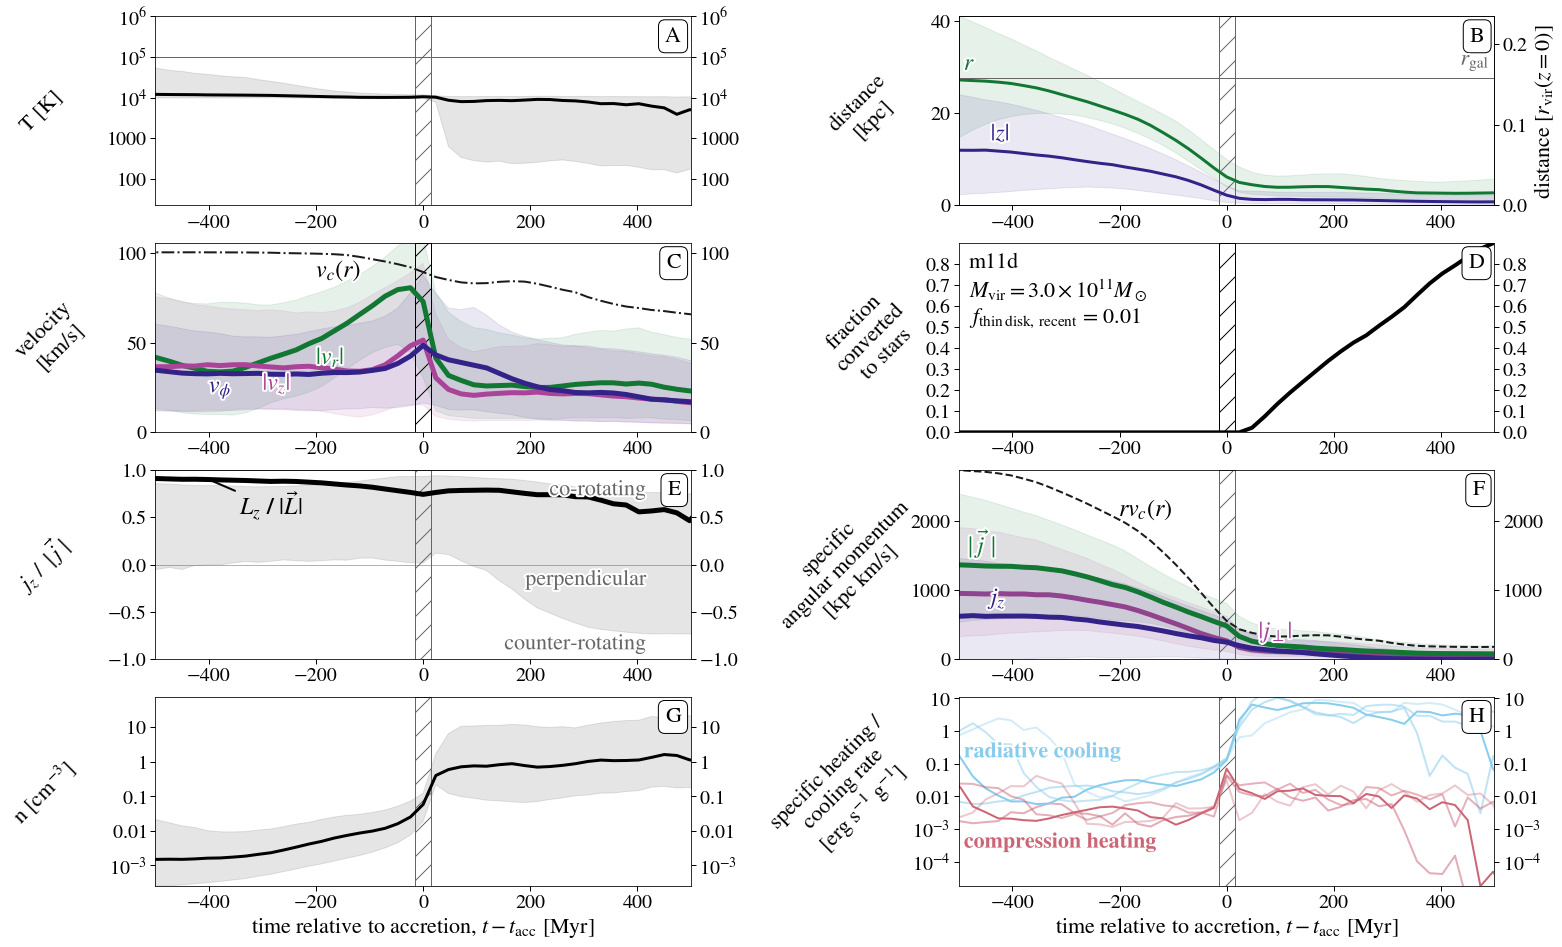

In [109]:
fig

In [110]:
plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'before_and_after' ),
    save_file = 'before_and_after_allone_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/variations/relative_to_accretion/before_and_after/before_and_after_allone_m11d_md.pdf


#### Additional Calculations

In [111]:
vdisp = np.sqrt( np.sum([ np.nanstd( _, axis=0 )**2. for _ in v_rolled ], axis=0) )

In [112]:
cs = 100. * np.sqrt( rolled['T'].value / 4.5e5 )
machrabs = vrabs / cs
machr = vr / cs

#### Save Plot Data for Reuse

In [113]:
before_after_plot_data = {
    'time': time,
    'temperature': {
        'median': med_gas_temp,
        'low': low_gas_temp,
        'high': high_gas_temp,
    },
    'radius': {
        'median': r_med,
        'low': r_low,
        'high': r_high,
    },
    'absolute_height': {
        'median': z_med,
        'low': z_low,
        'high': z_high,
    },
    'absolute_height_ratio': {
        'median': np.nanmedian( z_abs / r, axis=0 ),
        'low': np.nanpercentile( z_abs / r, 16, axis=0 ),
        'high': np.nanpercentile( z_abs / r, 84, axis=0 ),
    },
   'radial_velocity': {
        'median': np.nanmedian( vr, axis=0 ),
        'low': np.nanpercentile( vr, 16, axis=0 ),
        'high': np.nanpercentile( vr, 84, axis=0 ),
    },
    'vertical_velocity': {
        'median': np.nanmedian( vz, axis=0 ),
        'low': np.nanpercentile( vz, 16, axis=0 ),
        'high': np.nanpercentile( vz, 84, axis=0 ),
    },
    'tangential_velocity': {
        'median': np.nanmedian( vphi, axis=0 ),
        'low': np.nanpercentile( vphi, 16, axis=0 ),
        'high': np.nanpercentile( vphi, 84, axis=0 ),
    },
   'absolute_radial_velocity': {
        'median': vr_med,
        'low': vr_low,
        'high': vr_high,
    },
    'absolute_vertical_velocity': {
        'median': vz_med,
        'low': vz_low,
        'high': vz_high,
    },
    'absolute_tangential_velocity': {
        'median': vphi_med,
        'low': vphi_low,
        'high': vphi_high,
    },
    'radial_mach_number': {
        'median': np.nanmedian( machr, axis=0 ),
        'low': np.nanpercentile( machr, 16, axis=0 ),
        'high': np.nanpercentile( machr, 84, axis=0 ),
    },
    'absolute_radial_mach_number': {
        'median': np.nanmedian( machrabs, axis=0 ),
        'low': np.nanpercentile( machrabs, 16, axis=0 ),
        'high': np.nanpercentile( machrabs, 84, axis=0 ),
    },
    'velocity_dispersion': vdisp,
    'radial_velocity_dispersion': np.nanstd( vr, axis=0 ),
    'vertical_velocity_dispersion': np.nanstd( vz, axis=0 ),
    'tangential_velocity_dispersion': np.nanstd( vphi, axis=0 ),
    'star_fraction': frac_star,
    'angular_momentum_alignment': {
        'median': c_med,
        'low': c_low,
        'high': c_high,
        'of_total': total_jz_jmag,
    },
    'angular_momentum_magnitude': {
        'median': j_med,
        'low': j_low,
        'high': j_high,
    },
    'aligned_angular_momentum': {
        'median': jz_med,
        'low': jz_low,
        'high': jz_high,
    },
    'perpendicular_angular_momentum': {
        'median': jperp_med,
        'low': jperp_low,
        'high': jperp_high,
    },
    'circular_angular_momentum': {
        'median': rvc_med,
        'low': rvc_low,
        'high': rvc_high, 
    },
    'rotational_support_ratio': {
        'median': np.nanmedian( jmag / rvc, axis=0 ),
        'low': np.nanpercentile( jmag / rvc, 16, axis=0 ),
        'high': np.nanpercentile( jmag / rvc, 84, axis=0 ),
    },
    'aligned_rotational_support_ratio': {
        'median': np.nanmedian( jz / rvc, axis=0 ),
        'low': np.nanpercentile( jz / rvc, 16, axis=0 ),
        'high': np.nanpercentile( jz / rvc, 84, axis=0 ),
    },
    'torque_magnitude': {
        'median': np.nanpercentile( djmag, 50., axis=0 ),
        'low': np.nanpercentile( djmag, 16., axis=0 ),
        'high': np.nanpercentile( djmag, 84., axis=0 ),
    },
    'aligned_torque': {
        'median': np.nanpercentile( djz, 50., axis=0 ),
        'low': np.nanpercentile( djz, 16., axis=0 ),
        'high': np.nanpercentile( djz, 84., axis=0 ),
    },
    'aligned_torque_fraction': {
        'median': np.nanpercentile( djz / djmag, 50., axis=0 ),
        'low': np.nanpercentile( djz / djmag, 16., axis=0 ),
        'high': np.nanpercentile( djz / djmag, 84., axis=0 ),
    },
    'perpendicular_torque': {
        'median': np.nanpercentile( djperp, 50., axis=0 ),
        'low': np.nanpercentile( djperp, 16., axis=0 ),
        'high': np.nanpercentile( djperp, 84., axis=0 ),
    },
    'perpendicular_torque_fraction': {
        'median': np.nanpercentile( djperp / djmag, 50., axis=0 ),
        'low': np.nanpercentile( djperp / djmag, 16., axis=0 ),
        'high': np.nanpercentile( djperp / djmag, 84., axis=0 ),
    },
    'density': {
        'median': med_gas_den,
        'low': low_gas_den,
        'high': high_gas_den,
    },
    'radiative_cooling': mean_rad_per_unit_mass,
    'compression_heating': mean_compress_per_unit_mass,
    'particles_per_tchange_bin': n_bin,
    'tchange_bins': tchange_bins,
}

In [114]:
try:
    before_after_plot_data['tdiff'] = tacc_tcools
except NameError:
    before_after_plot_data['tdiff'] = tcools_tacc

In [115]:
# Store for later use.
if 'before_after_plot_data' not in data:
    data['before_after_plot_data'] = {}
data['before_after_plot_data'][pm['variation']] = before_after_plot_data
data.to_hdf5( data_fp, handle_jagged_arrs='row datasets' )

100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


### Paper Version

#### Setup Top Half

In [116]:
nrows = 3
ncols = 2
fig = plt.figure( figsize=(12 * ncols, 4.5 * nrows), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=ncols, nrows=nrows, )
gs.update( wspace=0.35, )
leftlabelpad = 35.
rightlabelpad = 35.
def labelpad( i ):
    if i - (i//ncols) * ncols:
        return rightlabelpad
    else:
        return leftlabelpad

errt = 30./2.

rotation = 45.

panel_letters = 'ABCDEFGHIJK'

i = 0

<Figure size 1728x972 with 0 Axes>

In [117]:
def get_ax( i ):
    
#     if i == 0:
#         return fig.add_subplot( gs[0,:] )
    
#     j = i // nrows
#     return fig.add_subplot( gs[i - j * nrows, j] )

    j = i // ncols
    return fig.add_subplot( gs[j,i - j * ncols] )

#### Temperature

In [118]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Plot T
ax.plot(
    time,
    med_gas_temp,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_temp,
    high_gas_temp,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.axhline(
    10.**pm['logTcools'],
    color = pm['background_linecolor'],
    linewidth = 1,
)
if pm['central_indices'] == 'tcools_inds':
    ax.axvline(
        median_tacc * 1e3,
        color = pm['background_linecolor'],
        linewidth = 1,
    )
    ax.annotate(
        text = r'$\langle t_{\rm acc} \rangle$',
        xy = ( median_tacc * 1e3, 1. ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
        xytext = ( 5, -5 ),
        textcoords = 'offset points',
        fontsize = 22,
        color = pm['background_linecolor'],
        ha = 'left',
        va = 'top',
    )

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 1e2, 3e6 )
ax.set_ylabel(
    'T [K]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.set_yscale( 'log' )
ax.set_yticks( [1e2, 1e3, 1e4, 1e5, 1e6 ] )
ax.set_yticklabels( [ '100', '1000', r'$10^4$', r'$10^5$', r'$10^6$'] )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Distance

##### Radius

In [119]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

r_med = np.nanpercentile( r, 50., axis=0 )
ax.plot(
    time,
    r_med[inds2],
    color = colormap[3],
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( r, 16, axis=0 )[inds2],
    np.nanpercentile( r, 84., axis=0 )[inds2],
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, r_med[inds2] )( -500 )
text = ax.annotate(
    text =r'$r$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
#     color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
# ax.fill_betweenx(
#     [ 0., 1. ],
#     [ -errt, ]*2,
#     [ errt, ]*2,
#     transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
#     facecolor = 'none',
#     edgecolor = pm['background_linecolor'],
#     linewidth = 1.0,
#     hatch = '/',
# )
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = pm['background_linecolor'],
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

# ax.axhline(
#     w.r_gal[0],
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )
# ax.annotate(
# #     text =r'$4 r_\star(z=0)$',
#     text =r'$r_{\rm gal}$',
# #     text ='disk radius',
#     xy = ( 0, w.r_gal[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
#     color = pm['background_linecolor'],
#     fontweight = 'bold',
# )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 75 )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    'distance\n[kpc]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'distance [$r_{\rm vir}(z=0)$]', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
# i += 1


Text(0, 0.5, 'distance [$r_{\\rm vir}(z=0)$]')

##### Vertical Height

In [120]:
# ax = get_ax( i )

# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

z_abs = np.abs( z[:,inds2] )

ax.plot(
    time,
    np.nanmedian( z_abs, axis=0 ),
    color = colormap[4],
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( z_abs, 16, axis=0 ),
    np.nanpercentile( z_abs, 84., axis=0 ),
    color = colormap[4],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, z_med[inds2] )( -450 )
text = ax.annotate(
    text =r'$\vert z \vert$',
    xy = ( -450, y_annot ),
    xycoords = ax.transData,
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[4],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = pm['background_linecolor'],
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = pm['background_linecolor'],
    linewidth = 1,
)
text = ax.annotate(
#     text =r'$4 r_\star(z=0)$',
    text =r'$r_{\rm gal}$',
#     text ='disk radius',
    xy = ( 1, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'right',
    va = 'bottom',
    color = pm['background_linecolor'],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.set_xlim( -500, 500 )
# ax.set_ylim( 0, 1.5 * w.r_gal[0] )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
# ax.set_ylabel(
#     r'd [kpc]',
#     fontsize=22,
#     rotation=rotation,
#     va='center',
#     ha='center',
#     labelpad = labelpad( i ),
# )
    
# ax_r = ax.twinx()
# ax_ylim = ax.get_ylim()
# ax_r.set_ylim( np.array( ax_ylim ) / w.r_gal[ind] )
# ax_r.set_ylabel( r'$\mid z \mid /r_{\rm gal}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1

#### Velocity Components

In [121]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
# ax.annotate(
#     text =r'D: decoherent to coherent',
#     xy = ( 0, 0 ),
#     xycoords = 'axes fraction',
#     xytext = ( 10, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'left',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# Vr
vr_med = np.nanpercentile( vrabs, 50., axis=0 )
ax.plot(
    time,
    vr_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[3],
    linewidth = 5,
)
vr_low = np.nanpercentile( vrabs, 16, axis=0 )[inds2]
ax.fill_between(
    time,
    vr_low,
    np.nanpercentile( vrabs, 84., axis=0 )[inds2],
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vr_med[inds2] )( 50 )
text = ax.annotate(
    text =r'$\vert v_r \vert$',
    xy = ( 50, y_annot ),
    xycoords = 'data',
    xytext = ( 0, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vz
vz_med = np.nanpercentile( vzabs, 50., axis=0 )
ax.plot(
    time,
    vz_med[inds2],
    color = colormap[5],
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( vzabs, 16, axis=0 )[inds2],
    np.nanpercentile( vzabs, 84., axis=0 )[inds2],
    color = colormap[5],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vz_med[inds2] )( -300 )
text = ax.annotate(
    text =r'$\vert v_z \vert$',
    xy = ( -300, y_annot ),
    xycoords = 'data',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = colormap[5],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vphi
vphi_med = np.nanpercentile( vphi, 50., axis=0 )[inds2]
ax.plot(
    time,
    vphi_med,
    color = colormap[4],
    linewidth = 5,
)
vphi_high = np.nanpercentile( vphi, 84., axis=0 )[inds2]
ax.fill_between(
    time,
    np.nanpercentile( vphi, 16, axis=0 )[inds2],
    vphi_high,
    color = colormap[4],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vphi_med )( -150 )
text = ax.annotate(
    text =r'$v_\phi$',
    xy = ( -150, y_annot ),
    xycoords = 'data',
    xytext = ( 0, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'right',
    va = 'bottom',
    color = colormap[4],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vc
vc_med = np.nanpercentile( vc, 50., axis=0 )[inds2]
ax.plot(
    time,
    vc_med,
    color = '.1',
    linewidth = 2,
    linestyle = '-.',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( vc, 16, axis=0 )[inds2],
#     np.nanpercentile( vc, 84., axis=0 )[inds2],
#     color = colormap[2],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, vc_med )( -200 )
ax.annotate(
    text =r'$v_c(r)$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 0, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = 'k',
    fontweight = 'bold',
)

ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)

c_hot = 100. * np.sqrt( w.t_vir[snum] / 4.5e5 )
ax.axhline(
    c_hot,
    color = pm['background_linecolor'],
    linewidth = 1.,
)
ax.axhline(
    c_hot,
    color = pm['background_linecolor'],
    linewidth = 1.,
)
ax.annotate(
    text = r'$c_s(T_{\rm vir})$',
    xy = ( 300, c_hot ),
    xycoords = 'data',
    xytext = ( 0, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    color = pm['background_linecolor'],
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_yticks( np.arange( -1000, 1000, 50 ) )

ax.set_xlim( -500, 500 )
# ax.set_ylim( vr_low[time>-500.].min(), 1.2*vc_med[time<500.].max() )
ax.set_ylim( 0., 1.2*vc_med[time<500.].max() )
ax.set_ylabel(
    'velocity\n[km/s]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

In [122]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

#### Star Fraction

In [123]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

frac_star = ( ( rolled['PType'] == 4 ).sum( axis=0 ) / rolled['PType'].shape[0] )[inds2]

# Plot Fractions

# ax.plot(
#     time,
#     frac_ism,
#     color = colormap[3],
#     linewidth = 4,
#     label = 'ISM fraction',
# )

# ax.plot(
#     time,
#     frac_dense,
#     color = colormap[5],
#     linewidth = 4,
#     label = r'$n > 10$ cm$^{-3}$ fraction',
# )

ax.plot(
    time,
    frac_star,
    color = 'k',
    linewidth = 4,
    label = 'stellar fraction',
)


# ax.plot(
#     time,
#     frac_dense_or_star,
#     color = colormap[2],
#     linewidth = 4,
#     label = r'dense or stellar fraction',
# )

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# sim = pm['variation']
# sim_label = r'$f_{\rm thin\,disk,\,recent}$ = ' + '{:.2g}'.format( np.round( data[pm['thin_disk_frac_key']][sim], 2 ) ) + '\n'
# sim_label += r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( w.m_vir[snum], 2 ) +  r'M_\odot$' + '\n'
# sim_label += sim.split( '_' )[0]
# ax.annotate(
#     text = sim_label,
#     xy = ( 0, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 7, -7 ),
#     textcoords = 'offset points',
#     ha = 'left',
#     va = 'top',
#     fontsize = 22,
#     color = 'k',
# )

ax.set_yticks( np.arange( 0., 0.6, 0.1 ) )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 0.5 )
ax.set_ylabel(
#     r'$n_\star$ / $n_{\rm total}$',
    'fraction\nconverted\nto stars',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = 55.0,
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
# i += 1

# ax.legend(
#     prop = { 'size': 16 },
# )

#### Label Panel

In [124]:

# ax = get_ax( i )

sim = pm['variation']
sim_label = sim.split( '_' )[0] + '\n'
sim_label += r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( w.m_vir[snum], 2 ) +  r'M_\odot$' + '\n'
sim_label += r'$f_{\rm thin\,disk,\,recent}$ = ' + '{:.2g}'.format( np.round( default_data[pm['thin_disk_frac_key']][sim], 2 ) )
ax.annotate(
    text = sim_label,
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'top',
    fontsize = 28,
    color = 'k',
)

# # Remove axes
# for spine in list( ax.spines.values() ):
#     spine.set_visible( False )
# ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )

i += 1

In [125]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

#### Save Top Half

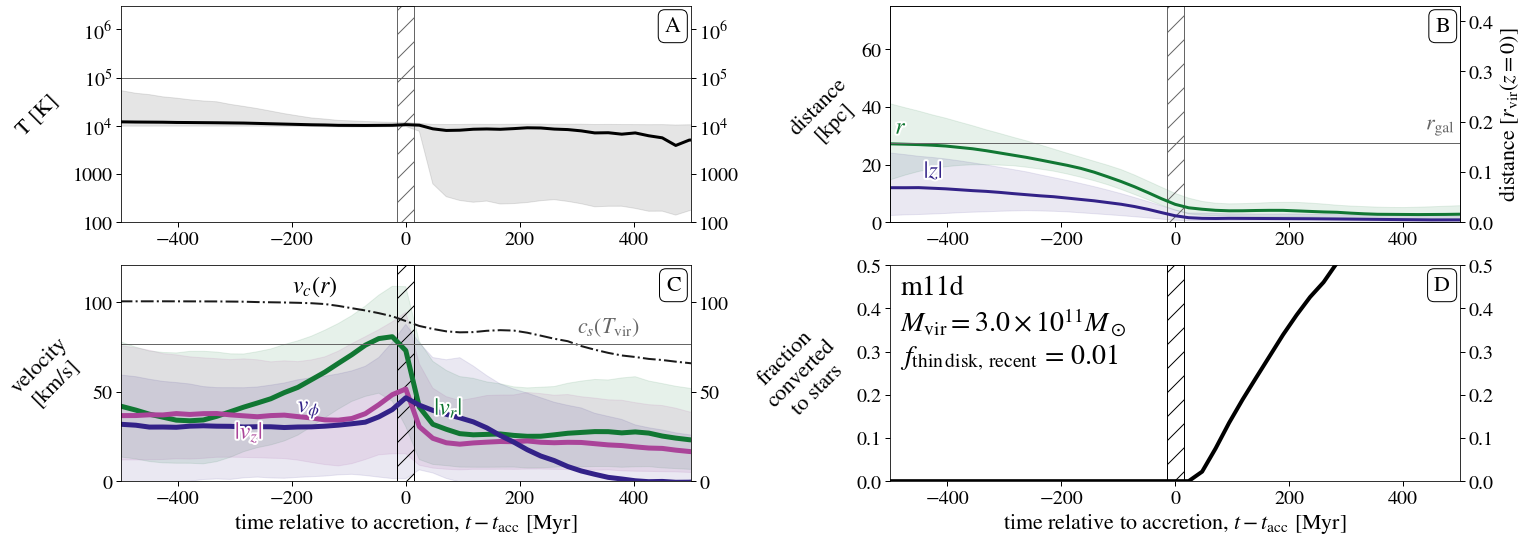

In [126]:
fig

In [127]:
plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'before_and_after' ),
    save_file = 'before_and_after_characteristics_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/variations/relative_to_accretion/before_and_after/before_and_after_characteristics_m11d_md.pdf


#### Setup Bottom Half

In [128]:
nrows = 2
ncols = 2
fig = plt.figure( figsize=(12 * ncols, 4.5 * nrows), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=ncols, nrows=nrows, )
gs.update( wspace=0.45, )
leftlabelpad = 45.
rightlabelpad = 55.
def labelpad( i ):
    if i - (i//ncols) * ncols:
        return rightlabelpad
    else:
        return leftlabelpad

errt = 30./2.

panel_letters = 'ABCDEFGHIJK'

i = 0

<Figure size 1728x648 with 0 Axes>

In [129]:
def get_ax( i ):
    
#     if i == 0:
#         return fig.add_subplot( gs[0,:] )
    
#     j = i // nrows
#     return fig.add_subplot( gs[i - j * nrows, j] )

    j = i // ncols
    return fig.add_subplot( gs[j,i - j * ncols] )

#### Circularity

In [130]:
ax = get_ax( i )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
ax.annotate(
    text = panel_letters[i],
    xy = ( 0, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

ax.annotate(
    text = 'hot CGM',
    xy = ( 0.25, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 0, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'center',
    fontsize = 22,
)
ax.annotate(
    text = 'ISM',
    xy = ( 0.75, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 0, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'center',
    fontsize = 22,
)

c = jz / jmag
c_med = np.nanpercentile( c, 50., axis=0 )
# ax.plot(
#     time,
#     c_med[inds2],
# #     total_jz_jmag[inds2],
#     color = 'k',
#     linewidth = 5,
# )
ax.fill_between(
    time,
    np.nanpercentile( c, 16, axis=0 )[inds2],
    np.nanpercentile( c, 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linewidth = 5,
)
y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -400 )
text = ax.annotate(
    text =r'$L_z$ / $\vert \vec L \vert$',
    xy = ( -400, y_annot ),
    xycoords = 'data',
    xytext = ( 30, -10 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
    arrowprops = {
        'arrowstyle': '-',
        'lw': 2,
        'color': 'k',
    },
)
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# # Net jz/j in bins
# for i, jz_jmag in enumerate( mean_jz_jmag ):
#     ax.plot(
#         time,
#         jz_jmag[inds2],
#         color = 'k',
#         alpha = n_bin[i]/n_bin.max(),
#         linewidth = 2,
#         linestyle = '--',
#     )

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)
# y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
# ax.annotate(
#     text =r'$L_z$ / $\mid \vec L \mid$',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -2.5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

# # Circulation
# ax.plot(
#     time,
#     circulation[inds2],
#     color = 'k',
#     linestyle = '-.',
#     linewidth = 2,
# )


ax.axhline(
    1,
    color = pm['background_linecolor'],
    linewidth = 1,
)
ax.annotate(
    text ='co-rotating',
    xy = ( 1, 1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)
ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)
ax.annotate(
    text ='perpendicular',
    xy = ( 1, 0 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)
ax.annotate(
    text ='counter-rotating',
    xy = ( 1, -1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)

ax.set_xlim( -500, 500 )
ax.set_ylim( -1, 1 )
ax.set_ylabel(
    r'$j_z$ / $\mid \vec j \mid$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )

i += 1

#### Angular Momentum Components

In [131]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 0, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 10, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

ax.annotate(
    text = 'hot CGM',
    xy = ( 0.25, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 0, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'center',
    fontsize = 22,
)
ax.annotate(
    text = 'ISM',
    xy = ( 0.75, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 0, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'center',
    fontsize = 22,
)

sim = pm['variation']
sim_label = r'$f_{\rm thin\,disk,\,recent}$ = ' + '{:.2g}'.format( np.round( default_data[pm['thin_disk_frac_key']][sim], 2 ) ) + '\n'
# sim_label += r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( w.m_vir[snum], 2 ) +  r'M_\odot$' + '\n'
sim_label += sim.split( '_' )[0]
ax.annotate(
    text = sim_label,
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -7, -7 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'top',
    fontsize = 22,
    color = 'k',
)

# Total angular momentum
j_med = np.nanpercentile( jmag, 50., axis=0 )[inds2]
ax.plot(
    time,
    j_med,
    color = colormap[3],
#     color = 'k',
    linewidth = 5,
)
# ax.plot(
#     time,
#     total_jmag[inds2],
#     color = colormap[3],
# #     color = 'k',
#     linewidth = 5,
#     linestyle = '--',
# )
ax.fill_between(
    time,
    np.nanpercentile( jmag, 16, axis=0 )[inds2],
    np.nanpercentile( jmag, 84., axis=0 )[inds2],
    color = colormap[3],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, j_med )( -450 )
text = ax.annotate(
    text =r'$\mid \vec j \mid$',
    xy = ( -450, y_annot ),
    xycoords = ax.transData,
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
#     color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# z-component angular momentum
jz_med = np.nanpercentile( jz, 50., axis=0 )[inds2]
ax.plot(
    time,
    jz_med,
    color = colormap[4],
#     color = 'k',
    linewidth = 5,
)
# ax.plot(
#     time,
#     total_jz[inds2],
#     color = colormap[4],
# #     color = 'k',
#     linewidth = 5,
#     linestyle = '--',
# )
ax.fill_between(
    time,
    np.nanpercentile( jz, 16, axis=0 )[inds2],
    np.nanpercentile( jz, 84., axis=0 )[inds2],
    color = colormap[4],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, jz_med )( -450 )
text = ax.annotate(
    text =r'$j_z$',
    xy = ( -450, y_annot ),
    xycoords = ax.transData,
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[4],
#     color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Rvc
rvc_med = np.nanpercentile( rvc, 50., axis=0 )
ax.plot(
    time,
    rvc_med[inds2],
#     color = colormap[4],
    color = '.1',
    linewidth = 2,
    linestyle = '--',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( rvc, 84., axis=0 )[inds2],
#     color = colormap[4],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, rvc_med[inds2] )( -200 )
ax.annotate(
    text =r'$rv_c(r)$',
    xy = ( -200, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
#     color = colormap[4],
    color = 'k',
    fontweight = 'bold',
)

# # Alternative that's the ratio
# j_med = np.nanpercentile( jmag / rvc, 50., axis=0 )
# ax.plot(
#     time,
#     j_med[inds2],
#     color = 'k',
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     np.nanpercentile( jmag / rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( jmag / rvc, 84., axis=0 )[inds2],
#     color = 'k',
#     alpha = 0.1,
# )
# ax.axhline(
#     1.,
#     color = pm['background_linecolor'],
#     linestyle = '--',
# )

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# ax.axhline(
#     j_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = pm['background_linecolor'],
# )
# ax.annotate(
#     text =r'$j(t=t_{10^5{\rm K}})$',
#     xy = ( -200, j_med[0] ),
# #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'right',
#     va = 'top',
# )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 8100 )
# ax.set_ylim( 0, 1. )
ax.set_ylabel(
    'specific\nangular momentum\n[kpc km/s]',
#     r'$\mid \vec j \mid / (\, Rv_c(R)\, )$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )
i += 1

#### Density

In [132]:
ax = get_ax( i )

ax.annotate(
#     text =r'{}: CGM to ISM'.format( panel_letters[i] ),
    text = panel_letters[i],
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# ax.annotate(
#     text =r'A: hot to cool',
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# Plot Den
ax.plot(
    time,
    med_gas_den,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_den,
    high_gas_den,
    color = 'k',
    alpha = 0.1,
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# ngal_baryon = 0.173
# ax.axhline(
#     ngal_baryon,
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )
# ax.annotate(
#     text =r'$n_{\rm gal}$',
#     xy = ( -errt, ngal_baryon ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
# )

# n_SF = 100
# ax.axhline(
#     n_SF,
#     color = pm['background_linecolor'],
#     linewidth = 2,
# )
# ax.annotate(
#     text ='minimum density for\nstar formation',
#     xy = ( -50, n_SF ),
#     xycoords = 'data',
#     xytext = ( 0, -20 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 24,
#     arrowprops = {
#         'arrowstyle': '-',
#         'lw': 2,
#         'color': pm['background_linecolor'],
#     },
#     color = pm['background_linecolor'],
# )

ax.set_xlim( -500, 500 )
ax.set_ylabel(
    'n [cm$^{-3}$]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
ax.set_yticks( 10.**np.arange(-5, 5, 1 ) )
# ax.set_ylim( 1e-4, n_SF*2 )
ax.set_ylim( 1e-4, high_gas_den[time>-500.].max() )

i += 1

In [133]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

#### Energy

In [134]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for j, rad in enumerate( mean_rad_per_unit_mass ):
    
#     # Don't look at edge cases from early on
#     if tchange_bins[i] < 12:
#         continue
    
    ax.plot(
        time,
        rad[inds2],
        color = colormap[0],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )
    ax.plot(
        time,
        mean_compress_per_unit_mass[j][inds2],
        color = colormap[1],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )

# ax.plot(
#     time,
#     np.nanmean( rad_per_unit_mass, axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     linestyle = '--',
# )
# ax.plot(
#     time,
#     np.nanmean( compress_per_unit_mass, axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     linestyle = '--',
# )
# Total mean
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( rad_per_unit_mass ), axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     label = 'radiation',
# )
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( compress_per_unit_mass ), axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     label = 'compression',
# )

text = ax.annotate(
    text ='radiative cooling',
    xy = ( 1, 1. ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -15 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = colormap[0],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])
text = ax.annotate(
    text ='compression heating',
    xy = ( 1, 4e-3 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 15 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = colormap[1],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)
    
# ax.annotate(
#     text ='mean',
#     xy = ( 0, 1 ),
#     xytext = ( 5, -5 ),
#     xycoords = 'axes fraction',
#     textcoords = 'offset points',
#     fontsize = 22,
#     va = 'top',
#     ha = 'left',
# )

ax.set_yscale( 'log' )
ax.set_xlim( -500, 500 )
ax.set_ylim( 2e-3, 10**0.3 )
# ax.legend( prop={'size': 18}, loc='lower left', )
ax.tick_params( which='both', right=True, labelright=True, )

ax.set_ylabel(
#     'net change in\nspecific energy\n' + r'[${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]',
    'specific heating /\ncooling rate\n' + r'[${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)

i += 1

In [135]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

#### Save Bottom Half

In [136]:
plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'before_and_after' ),
    save_file = 'before_and_after_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/variations/relative_to_accretion/before_and_after/before_and_after_m11d_md.pdf


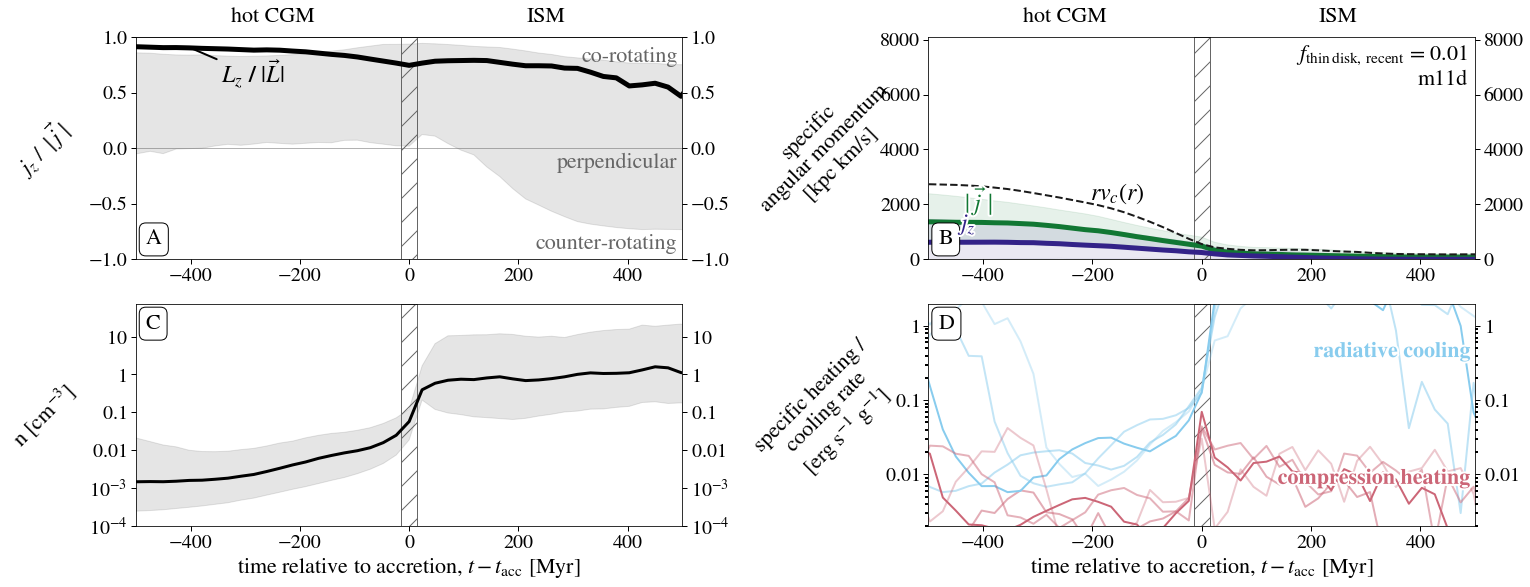

In [137]:
fig

### Proposal Version

In [138]:
colormap = palettable.cartocolors.qualitative.Safe_10.mpl_colors

#### Setup

In [139]:
nrows = 3
ncols = 1
fig = plt.figure( figsize=(12 * ncols, 4 * nrows), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=ncols, nrows=nrows, )
gs.update( wspace=0.50, )
leftlabelpad = 35.
rightlabelpad = 65.

def labelpad( i ):
    if i - (i//ncols) * ncols:
        return rightlabelpad
    else:
        return leftlabelpad

errt = 30./2.

rotation = 45.

i = 0

<Figure size 864x864 with 0 Axes>

In [140]:
def get_ax( i ):

    j = i // ncols
    return fig.add_subplot( gs[j,i - j * ncols] )

#### Distance

##### Radius

In [141]:
ax = get_ax( i )

ax.annotate(
    text = 'CGM',
    xy = ( 0.25, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 0, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'center',
    fontsize = 22,
)
ax.annotate(
    text = 'ISM',
    xy = ( 0.75, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 0, 10 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'center',
    fontsize = 22,
)

# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

r_med = np.nanpercentile( r, 50., axis=0 )
ax.plot(
    time,
    r_med[inds2],
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    np.nanpercentile( r, 16, axis=0 )[inds2],
    np.nanpercentile( r, 84., axis=0 )[inds2],
    color = 'k',
    alpha = 0.1,
)

##### Height

In [142]:
# z_abs = np.abs( z[:,inds2] )

# ax.plot(
#     time,
#     np.nanmedian( z_abs, axis=0 ),
#     color = colormap[5],
#     linewidth = 3,
# )
# ax.fill_between(
#     time,
#     np.nanpercentile( z_abs, 16, axis=0 ),
#     np.nanpercentile( z_abs, 84., axis=0 ),
#     color = colormap[5],
#     alpha = 0.1,
# )

In [143]:
# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = pm['background_linecolor'],
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = pm['background_linecolor'],
    linewidth = 1,
)
ax.annotate(
#     text =r'$4 r_\star(z=0)$',
    text =r'$r_{\rm gal}$',
#     text ='disk radius',
    xy = ( 0, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'left',
    va = 'bottom',
    color = pm['background_linecolor'],
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 90 )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    'r [kpc]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'r/$r_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1


#### Temperature

In [144]:
ax = get_ax( i )

# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )


# Plot T
ax.plot(
    time,
    med_gas_temp,
    color = 'k',
    linewidth = 3,
)
ax.fill_between(
    time,
    low_gas_temp,
    high_gas_temp,
    color = 'k',
    alpha = 0.1,
)

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)


ax.set_xlim( -500, 500 )
ax.set_ylim( 0.95*low_gas_temp.min(), 1.05*high_gas_temp.max() )
ax.set_ylabel(
    'T [K]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.set_yscale( 'log' )
ax.set_yticks( [1e2, 1e3, 1e4, 1e5, 1e6 ] )
ax.set_yticklabels( [ '100', '1000', r'$10^4$', r'$10^5$', r'$10^6$'] )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Circularity

In [145]:
ax = get_ax( i )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
# ax.annotate(
#     text = panel_letters[i],
#     xy = ( 0, 0 ),
#     xycoords = 'axes fraction',
#     xytext = ( 10, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'left',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

c = jz / jmag
c_med = np.nanpercentile( c, 50., axis=0 )
# ax.plot(
#     time,
#     c_med[inds2],
# #     total_jz_jmag[inds2],
#     color = 'k',
#     linewidth = 5,
# )
c_low = np.nanpercentile( c, 16, axis=0 )[inds2]
c_high = np.nanpercentile( c, 84., axis=0 )[inds2]
ax.fill_between(
    time,
    c_low,
    c_high,
    color = 'k',
    alpha = 0.1,
)
# y_annot = scipy.interpolate.interp1d( time, c_med[inds2] )( -500 )
# ax.annotate(
#     text =r'median',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# # Net jz/j in bins
# for i, jz_jmag in enumerate( mean_jz_jmag ):
#     ax.plot(
#         time,
#         jz_jmag[inds2],
#         color = 'k',
#         alpha = n_bin[i]/n_bin.max(),
#         linewidth = 2,
#         linestyle = '--',
#     )

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linewidth = 5,
)
y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -400 )
text = ax.annotate(
    text =r'$L_z$ / $\vert \vec L \vert$',
    xy = ( -400, y_annot ),
    xycoords = 'data',
    xytext = ( 30, -10 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
    arrowprops = {
        'arrowstyle': '-',
        'lw': 2,
        'color': 'k',
    },
)

y_annot = scipy.interpolate.interp1d( time, c_low )( -100 )
text = ax.annotate(
    text ='gas spin becomes coherent\n' + r'$\bf{prior}$ to accretion',
    xy = ( -100, y_annot ),
    xycoords = 'data',
    xytext = ( 10, -80 ),
    textcoords = 'offset points',
    fontsize = 20,
    ha = 'right',
    va = 'top',
    color = 'k',
    arrowprops = {
        'arrowstyle': '-',
        'lw': 2,
        'color': 'k',
    },
)


# # Circulation
# ax.plot(
#     time,
#     circulation[inds2],
#     color = 'k',
#     linestyle = '-.',
#     linewidth = 2,
# )


ax.axhline(
    1,
    color = pm['background_linecolor'],
    linewidth = 1,
)
ax.annotate(
    text ='co-rotating',
    xy = ( 1, 1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)
ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)
ax.annotate(
    text ='perpendicular',
    xy = ( 1, 0 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)
ax.annotate(
    text ='counter-rotating',
    xy = ( 1, -1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = pm['background_linecolor'],
)

ax.set_xlim( -500, 500 )
ax.set_ylim( -1, 1 )
ax.set_ylabel(
    r'$j_z$ / $\mid \vec j \mid$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )

i += 1

In [146]:
ax.set_xlabel( 'time relative to time of cooling / accretion [Myr]', fontsize=22 )

Text(0.5, 0, 'time relative to time of cooling / accretion [Myr]')

#### Display and Save

In [147]:
plotting.save_fig(
    out_dir = os.path.join( pm['root_data_dir'], 'temp' ),
    save_file = 'before_and_after_{}.pdf'.format( pm['variation'] ),
    fig = fig,
)

File saved at /scratch/03057/zhafen/hot_accretion_data/temp/before_and_after_m11d_md.pdf


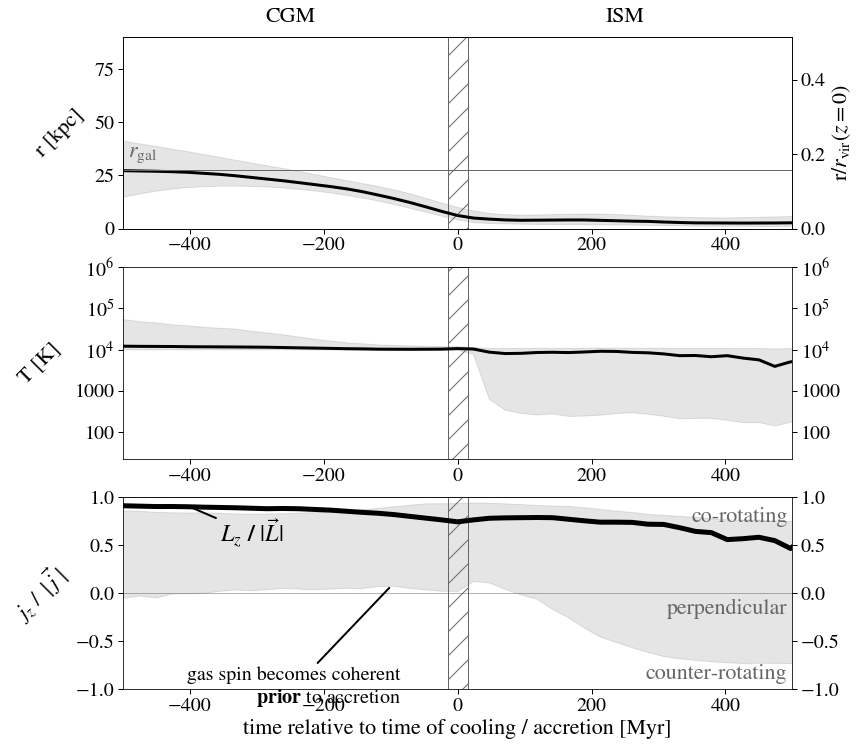

In [148]:
fig

### Angular Version

In [149]:
phi_bins = np.arange( 0., np.pi / 2. + 0.1, np.pi / 8. )
phi_bin_labels = [ r'$0-\pi/8$', r'$\pi/8-\pi4$', r'$\pi/4-3\pi/8$', r'$3\pi/8-\pi/2$',  ][::-1]
# phi_bins = np.arange( 0., np.pi / 2. + 0.1, np.pi / 4. )
# phi_bin_labels = [ r'$0-\pi/4$', r'$\pi/4-\pi/2$' ]

#### Calculate Gas Temperature and Density
Need to do this separately because we don't want stars messing up the temp

In [150]:
med_gas_temp = []
low_gas_temp = []
high_gas_temp = []
for i in tqdm.tqdm( inds2 ):
    gas_temp = rolled['T'][:,i][rolled['PType'][:,i]==0]
    gas_phi = rolled['AbsPhi'][:,i].to( 'radian' )
    med_gas_temp_bin = []
    low_gas_temp_bin = []
    high_gas_temp_bin = []
    for j, phi_start in enumerate( phi_bins[:-1] ):
        in_bin = ( ( gas_phi > phi_start ) & ( gas_phi < phi_bins[j+1] ) )[rolled['PType'][:,i]==0]
        med_gas_temp_bin.append( np.nanmedian( gas_temp[in_bin] ) )
        low_gas_temp_bin.append( np.nanpercentile( gas_temp[in_bin], 16. ) )
        high_gas_temp_bin.append( np.nanpercentile( gas_temp[in_bin], 84. ) )
    med_gas_temp.append( med_gas_temp_bin )
    low_gas_temp.append( low_gas_temp_bin )
    high_gas_temp.append( high_gas_temp_bin )
med_gas_temp = np.array( med_gas_temp ).transpose()
low_gas_temp = np.array( low_gas_temp ).transpose()
high_gas_temp = np.array( high_gas_temp ).transpose()

  0%|          | 0/150 [00:00<?, ?it/s]/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/work2/03057/zhafen/stampede2/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
100%|██████████| 150/150 [00:00<00:00, 327.36it/s]


In [151]:
med_gas_den = []
low_gas_den = []
high_gas_den = []
for i in tqdm.tqdm( inds2 ):
    gas_den = rolled['Den'][:,i][rolled['PType'][:,i]==0]
    gas_phi = rolled['AbsPhi'][:,i].to( 'radian' )
    med_gas_den_bin = []
    low_gas_den_bin = []
    high_gas_den_bin = []
    for j, phi_start in enumerate( phi_bins[:-1] ):
        in_bin = ( ( gas_phi > phi_start ) & ( gas_phi < phi_bins[j+1] ) )[rolled['PType'][:,i]==0]
        med_gas_den_bin.append( np.nanmedian( gas_den[in_bin] ) )
        low_gas_den_bin.append( np.nanpercentile( gas_den[in_bin], 16. ) )
        high_gas_den_bin.append( np.nanpercentile( gas_den[in_bin], 84. ) )
    med_gas_den.append( med_gas_den_bin )
    low_gas_den.append( low_gas_den_bin )
    high_gas_den.append( high_gas_den_bin )
med_gas_den = np.array( med_gas_den ).transpose()
low_gas_den = np.array( low_gas_den ).transpose()
high_gas_den = np.array( high_gas_den ).transpose()

100%|██████████| 150/150 [00:00<00:00, 332.48it/s]


#### Setup

In [152]:
nrows = 5
ncols = 2
fig = plt.figure( figsize=(12 * ncols, 4 * nrows), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=ncols, nrows=nrows, )
gs.update( wspace=0.50, )
leftlabelpad = 45.
rightlabelpad = 65.

def labelpad( i ):
    if i - (i//ncols) * ncols:
        return rightlabelpad
    else:
        return leftlabelpad

errt = 30./2.

rotation = 45.

panel_letters = 'A BCDEFGHIJK'

i = 0

<Figure size 1728x1440 with 0 Axes>

In [153]:
def get_ax( i ):
    
#     if i == 0:
#         return fig.add_subplot( gs[0,:] )
    
#     j = i // nrows
#     return fig.add_subplot( gs[i - j * nrows, j] )

    j = i // ncols
    return fig.add_subplot( gs[j,i - j * ncols] )

In [154]:
cmap = palettable.matplotlib.Plasma_5.mpl_colors

#### Temperature

In [155]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# Plot T
for j, phi_start in enumerate( phi_bins[:-1] ):
    ax.plot(
        time,
        med_gas_temp[j],
        color = cmap[j],
        linewidth = 3,
        label = phi_bin_labels[j]
    )
#     ax.fill_between(
#         time,
#         low_gas_temp[j],
#         high_gas_temp[j],
#         color = 'k',
#         alpha = 0.1,
#     )

# Label lines
ax.axhline(
    10.**pm['logTcools'],
    color = pm['background_linecolor'],
    linewidth = 1,
)

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)


ax.set_xlim( -500, 500 )
ax.set_ylim( 0.95*np.nanmin( med_gas_temp ), 1.05*np.nanmax( med_gas_temp ), )
ax.set_ylabel(
    'T [K]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.set_yscale( 'log' )
ax.set_yticks( [1e2, 1e3, 1e4, 1e5, 1e6 ] )
ax.set_yticklabels( [ '100', '1000', r'$10^4$', r'$10^5$', r'$10^6$'] )
ax.tick_params( right=True, labelright=True, )

ax.legend( loc='lower left', prop={'size': 16 } )

i += 1

#### Label Panel

In [156]:

ax = get_ax( i )

sim = pm['variation']
sim_label = sim.split( '_' )[0] + '\n'
sim_label += r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( w.m_vir[snum], 2 ) +  r'M_\odot$' + '\n'
sim_label += r'$f_{\rm thin\,disk,\,recent}$ = ' + '{:.2g}'.format( np.round( default_data[pm['thin_disk_frac_key']][sim], 2 ) )
ax.annotate(
    text = sim_label,
    xy = ( 0, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 7, 7 ),
    textcoords = 'offset points',
    ha = 'left',
    va = 'bottom',
    fontsize = 32,
    color = 'k',
)

# Remove axes
for spine in list( ax.spines.values() ):
    spine.set_visible( False )
ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )

i += 1

#### Radius

In [157]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for j, phi_start in enumerate( phi_bins[:-1] ):
    
    in_bin = ( rolled['AbsPhi'].to( 'radian' ) > phi_start ) & ( rolled['AbsPhi'].to( 'radian' ) < phi_bins[j+1] )

    r_med = np.nanpercentile( np.where( in_bin, r, np.nan ), 50., axis=0 )
    ax.plot(
        time,
        r_med[inds2],
        color = cmap[j],
        linewidth = 3,
    )
    
#     r_low = np.nanpercentile( r, 16, axis=0 )[inds2]
#     r_high = np.nanpercentile( r, 84., axis=0 )[inds2]
#     ax.fill_between(
#         time,
#         r_low,
#         r_high,
#         color = 'k',
#         alpha = 0.1,
#     )

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = pm['background_linecolor'],
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = pm['background_linecolor'],
    linewidth = 1,
)
ax.annotate(
#     text =r'$4 r_\star(z=0)$',
    text =r'$r_{\rm gal}$',
#     text ='disk radius',
    xy = ( 0, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'left',
    va = 'bottom',
    color = pm['background_linecolor'],
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, r_high[(time>-500.)&(time<500.)].max() )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    'r [kpc]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
ax_r.set_ylabel( r'r/$r_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1


#### Vertical Height

In [158]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for j, phi_start in enumerate( phi_bins[:-1] ):
    
    in_bin = ( rolled['AbsPhi'].to( 'radian' ) > phi_start ) & ( rolled['AbsPhi'].to( 'radian' ) < phi_bins[j+1] )
    z_bin = np.where( in_bin, z, np.nan )

    z_abs = np.abs( z_bin[:,inds2] )

    z_med = np.nanmedian( z_abs, axis=0 )
    ax.plot(
        time,
        z_med,
        color = cmap[j],
        linewidth = 3,
    )
#     z_low = np.nanpercentile( z_abs, 16, axis=0 )
#     z_high = np.nanpercentile( z_abs, 84., axis=0 )
#     ax.fill_between(
#         time,
#         z_low,
#         z_high,
#         color = 'k',
#         alpha = 0.1,
#     )


# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)
# ax.axhline(
#     r_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = pm['background_linecolor'],
# )
# ax.annotate(
#     text =r'$R(t=t_{10^5{\rm K}})$',
#     xy = ( 0, r_med[0] ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, 5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'left',
#     va = 'bottom',
# )

ax.axhline(
    w.r_gal[0],
    color = pm['background_linecolor'],
    linewidth = 1,
)
ax.annotate(
#     text =r'$4 r_\star(z=0)$',
    text =r'$r_{\rm gal}$',
#     text ='disk radius',
    xy = ( 1, w.r_gal[0] ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'right',
    va = 'top',
    color = pm['background_linecolor'],
    fontweight = 'bold',
)

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 3. * w.r_gal[0] )
# ax.set_yscale( 'log' )
# ax.set_ylim( 5, 100 )
ax.set_ylabel(
    r'$\mid z \mid$ [kpc]',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
    
ax_r = ax.twinx()
ax_ylim = ax.get_ylim()
ax_r.set_ylim( np.array( ax_ylim ) / w.r_gal[ind] )
ax_r.set_ylabel( r'$\mid z \mid /r_{\rm gal}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1

#### Velocity Components

In [159]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
# ax.annotate(
#     text =r'D: decoherent to coherent',
#     xy = ( 0, 0 ),
#     xycoords = 'axes fraction',
#     xytext = ( 10, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'left',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

for j, phi_start in enumerate( phi_bins[:-1] ):
    
    in_bin = ( rolled['AbsPhi'].to( 'radian' ) > phi_start ) & ( rolled['AbsPhi'].to( 'radian' ) < phi_bins[j+1] )
    vr_bin = np.where( in_bin, vr, np.nan )
    
    # Vr
    vr_med = np.nanpercentile( vr_bin, 50., axis=0 )
    ax.plot(
        time,
        vr_med[inds2],
    #     total_jz_jmag[inds2],
        color = cmap[j],
        linewidth = 5,
        label = [ None, 'Vr' ][j==0],
    )
    vr_low = np.nanpercentile( vr, 16, axis=0 )[inds2]
#     ax.fill_between(
#         time,
#         vr_low,
#         np.nanpercentile( vr, 84., axis=0 )[inds2],
#         color = colormap[3],
#         alpha = 0.1,
#     )
y_annot = scipy.interpolate.interp1d( time, vr_med[inds2] )( -200 )
text = ax.annotate(
    text =r'$v_r$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = colormap[3],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vz
for j, phi_start in enumerate( phi_bins[:-1] ):
    
    in_bin = ( rolled['AbsPhi'].to( 'radian' ) > phi_start ) & ( rolled['AbsPhi'].to( 'radian' ) < phi_bins[j+1] )
    vzabs_bin = np.where( in_bin, vzabs, np.nan )
    
    vz_med = np.nanpercentile( vzabs_bin, 50., axis=0 )
    ax.plot(
        time,
        vz_med[inds2],
    #     total_jz_jmag[inds2],
        color = cmap[j],
        linewidth = 5,
        linestyle = '--',
        label = [ None, 'Vz' ][j==0],
    )
# ax.fill_between(
#     time,
#     np.nanpercentile( vzabs, 16, axis=0 )[inds2],
#     np.nanpercentile( vzabs, 84., axis=0 )[inds2],
#     color = colormap[5],
#     alpha = 0.1,
# )
if sim_name == 'm12b_md':
    y_offset = 5
    va = 'bottom'
else:
    y_offset = 5
    va = 'bottom'
y_annot = scipy.interpolate.interp1d( time, vz_med[inds2] )( -300 )
text = ax.annotate(
    text =r'$v_{\vert z \vert}$',
    xy = ( -300, y_annot ),
    xycoords = 'data',
    xytext = ( 0, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[5],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vphi
for j, phi_start in enumerate( phi_bins[:-1] ):
    
    in_bin = ( rolled['AbsPhi'].to( 'radian' ) > phi_start ) & ( rolled['AbsPhi'].to( 'radian' ) < phi_bins[j+1] )
    vphi_bin = np.where( in_bin, vphi, np.nan )
    vphi_med = np.nanpercentile( vphi_bin, 50., axis=0 )[inds2]
    ax.plot(
        time,
        vphi_med,
        color = cmap[j],
        linewidth = 5,
        linestyle = ':',
        label = [ None, 'Vphi' ][j==0],
    )
    vphi_high = np.nanpercentile( vphi, 84., axis=0 )[inds2]
# ax.fill_between(
#     time,
#     np.nanpercentile( vphi, 16, axis=0 )[inds2],
#     vphi_high,
#     color = colormap[4],
#     alpha = 0.1,
# )
if sim_name == 'm12b_md':
    y_offset = 5
    va = 'bottom'
else:
    y_offset = 5
    va = 'bottom'
y_annot = scipy.interpolate.interp1d( time, vphi_med )( -400 )
text = ax.annotate(
    text =r'$v_\phi$',
    xy = ( -400, y_annot ),
    xycoords = 'data',
    xytext = ( 0, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[4],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vc
vc_med = np.nanpercentile( vc, 50., axis=0 )[inds2]
ax.plot(
    time,
    vc_med,
    color = '.1',
    linewidth = 2,
    linestyle = '-.',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( vc, 16, axis=0 )[inds2],
#     np.nanpercentile( vc, 84., axis=0 )[inds2],
#     color = colormap[2],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, vc_med )( -200 )
text = ax.annotate(
    text =r'$v_c(R)$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.axhline(
    1,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_yticks( np.arange( -1000, 1000, 50 ) )

ax.set_xlim( -500, 500 )
ax.set_ylim( vr_low[time>-500.].min(), 1.05*vc_med[time<500.].max() )
ax.set_ylabel(
    'velocity\n[km/s]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )

l = ax.legend( loc='lower right', prop={'size': 16 }, )
l.set_alpha( 1. )

i += 1

#### Star Fraction

In [160]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

frac_star = ( ( rolled['PType'] == 4 ).sum( axis=0 ) / rolled['PType'].shape[0] )[inds2]

# Plot Fractions

# ax.plot(
#     time,
#     frac_ism,
#     color = colormap[3],
#     linewidth = 4,
#     label = 'ISM fraction',
# )

# ax.plot(
#     time,
#     frac_dense,
#     color = colormap[5],
#     linewidth = 4,
#     label = r'$n > 10$ cm$^{-3}$ fraction',
# )

ax.plot(
    time,
    frac_star,
    color = 'k',
    linewidth = 4,
    label = 'stellar fraction',
)


# ax.plot(
#     time,
#     frac_dense_or_star,
#     color = colormap[2],
#     linewidth = 4,
#     label = r'dense or stellar fraction',
# )

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

# sim = pm['variation']
# sim_label = r'$f_{\rm thin\,disk,\,recent}$ = ' + '{:.2g}'.format( np.round( data[pm['thin_disk_frac_key']][sim], 2 ) ) + '\n'
# sim_label += r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( w.m_vir[snum], 2 ) +  r'M_\odot$' + '\n'
# sim_label += sim.split( '_' )[0]
# ax.annotate(
#     text = sim_label,
#     xy = ( 0, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 7, -7 ),
#     textcoords = 'offset points',
#     ha = 'left',
#     va = 'top',
#     fontsize = 22,
#     color = 'k',
# )

ax.set_yticks( np.arange( 0., 0.6, 0.1 ) )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, 0.5 )
ax.set_ylabel(
#     r'$n_\star$ / $n_{\rm total}$',
    'fraction\nconverted\nto stars',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = 55.0,
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

# ax.legend(
#     prop = { 'size': 16 },
# )

#### Circularity

In [161]:
ax = get_ax( i )

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# ax.annotate(
#     text = 'hot CGM',
#     xy = ( 0.25, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 0, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'center',
#     fontsize = 22,
# )
# ax.annotate(
#     text = 'ISM',
#     xy = ( 0.75, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 0, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'center',
#     fontsize = 22,
# )

for j, phi_start in enumerate( phi_bins[:-1] ):
    
    c = jz / jmag
    
    in_bin = ( rolled['AbsPhi'].to( 'radian' ) > phi_start ) & ( rolled['AbsPhi'].to( 'radian' ) < phi_bins[j+1] )
    c_bin = np.where( in_bin, c, np.nan )

    c_med = np.nanpercentile( c_bin, 50., axis=0 )
    ax.plot(
        time,
        c_med[inds2],
    #     total_jz_jmag[inds2],
        color = cmap[j],
        linewidth = 5,
    )
# ax.fill_between(
#     time,
#     np.nanpercentile( c, 16, axis=0 )[inds2],
#     np.nanpercentile( c, 84., axis=0 )[inds2],
#     color = 'k',
#     alpha = 0.1,
# )
# y_annot = scipy.interpolate.interp1d( time, c_med[inds2] )( -500 )
# ax.annotate(
#     text =r'median',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# # Net jz/j in bins
# for i, jz_jmag in enumerate( mean_jz_jmag ):
#     ax.plot(
#         time,
#         jz_jmag[inds2],
#         color = 'k',
#         alpha = n_bin[i]/n_bin.max(),
#         linewidth = 2,
#         linestyle = '--',
#     )

# Net jz/j
ax.plot(
    time,
    total_jz_jmag[inds2],
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)
# y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
# ax.annotate(
#     text =r'$L_z$ / $\mid \vec L \mid$',
#     xy = ( 0, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xytext = ( 5, -2.5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'left',
#     fontsize = 22,
# )

# # Circulation
# ax.plot(
#     time,
#     circulation[inds2],
#     color = 'k',
#     linestyle = '-.',
#     linewidth = 2,
# )

if sim_name == 'm12b_md':
    x_pos = 0.9
    x_offset = -5
    ha = 'right'
else:
    x_pos = 0
    x_offset = 5
    ha = 'left'
ax.axhline(
    1,
    color = pm['background_linecolor'],
    linewidth = 1,
)
ax.annotate(
    text ='co-rotating',
    xy = ( x_pos, 1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( x_offset, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = ha,
    fontsize = 22,
    color = pm['background_linecolor'],
)
ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)
ax.annotate(
    text ='perpendicular',
    xy = ( x_pos, 0 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( x_offset, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = ha,
    fontsize = 22,
    color = pm['background_linecolor'],
)
ax.annotate(
    text ='counter-rotating',
    xy = ( x_pos, -1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( x_offset, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = ha,
    fontsize = 22,
    color = pm['background_linecolor'],
)

ax.set_xlim( -500, 500 )
ax.set_ylim( -1, 1 )
ax.set_ylabel(
    r'$j_z$ / $\mid \vec j \mid$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )

i += 1

#### Angular Momentum Components

In [162]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# ax.annotate(
#     text = 'hot CGM',
#     xy = ( 0.25, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 0, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'center',
#     fontsize = 22,
# )
# ax.annotate(
#     text = 'ISM',
#     xy = ( 0.75, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 0, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'center',
#     fontsize = 22,
# )

# sim = pm['variation']
# sim_label = r'$f_{\rm thin\,disk,\,recent}$ = ' + '{:.2g}'.format( np.round( data[pm['thin_disk_frac_key']][sim], 2 ) ) + '\n'
# # sim_label += r'$M_{\rm vir}=' + py2tex.to_tex_scientific_notation( w.m_vir[snum], 2 ) +  r'M_\odot$' + '\n'
# sim_label += sim.split( '_' )[0]
# ax.annotate(
#     text = sim_label,
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -7, -7 ),
#     textcoords = 'offset points',
#     ha = 'right',
#     va = 'top',
#     fontsize = 22,
#     color = 'k',
# )

# Total angular momentum
j_med = np.nanpercentile( jmag, 50., axis=0 )[inds2]
ax.plot(
    time,
    j_med,
    color = colormap[3],
#     color = 'k',
    linewidth = 5,
)
ax.fill_between(
    time,
    np.nanpercentile( jmag, 16, axis=0 )[inds2],
    np.nanpercentile( jmag, 84., axis=0 )[inds2],
    color = colormap[3],
#     color = 'k',
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, j_med )( -500 )
text = ax.annotate(
    text =r'$\mid \vec j \mid$',
    xy = ( 0, y_annot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
    color = colormap[3],
#     color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

for j, phi_start in enumerate( phi_bins[:-1] ):
        
    in_bin = ( rolled['AbsPhi'].to( 'radian' ) > phi_start ) & ( rolled['AbsPhi'].to( 'radian' ) < phi_bins[j+1] )
    jz_bin = np.where( in_bin, jz, np.nan )

    # z-component angular momentum
    jz_med = np.nanpercentile( jz_bin, 50., axis=0 )[inds2]
    jz_low = np.nanpercentile( jz_bin, 16, axis=0 )[inds2]
    jz_high = np.nanpercentile( jz_bin, 84., axis=0 )[inds2]
    ax.plot(
        time,
        jz_med,
        color = cmap[j],
    #     color = 'k',
        linewidth = 5,
    )
# ax.fill_between(
#     time,
#     jz_low,
#     jz_high,
#     color = colormap[4],
# #     color = 'k',
#     alpha = 0.1,
# )
if sim_name == 'm12b_md':
    y_offset = -5
    va = 'top'
else:
    y_offset = 5
    va = 'bottom'
y_annot = scipy.interpolate.interp1d( time, jz_med )( -450 )
text = ax.annotate(
    text =r'$j_z$',
    xy = ( -450, y_annot ),
    xycoords = ax.transData,
    xytext = ( 5, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[4],
#     color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Rvc
rvc_med = np.nanpercentile( rvc, 50., axis=0 )[inds2]
ax.plot(
    time,
    rvc_med,
#     color = colormap[4],
    color = '.1',
    linewidth = 2,
    linestyle = '--',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( rvc, 84., axis=0 )[inds2],
#     color = colormap[4],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, rvc_med )( -200 )
ax.annotate(
    text =r'$Rv_c(R)$',
    xy = ( -200, y_annot ),
#     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -2, -2 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'bottom',
#     color = colormap[4],
    color = 'k',
    fontweight = 'bold',
)

# # Alternative that's the ratio
# j_med = np.nanpercentile( jmag / rvc, 50., axis=0 )
# ax.plot(
#     time,
#     j_med[inds2],
#     color = 'k',
#     linewidth = 5,
# )
# ax.fill_between(
#     time,
#     np.nanpercentile( jmag / rvc, 16, axis=0 )[inds2],
#     np.nanpercentile( jmag / rvc, 84., axis=0 )[inds2],
#     color = 'k',
#     alpha = 0.1,
# )
# ax.axhline(
#     1.,
#     color = pm['background_linecolor'],
#     linestyle = '--',
# )

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# ax.axhline(
#     j_med[0],
#     linewidth = 1.5,
#     linestyle = '--',
#     color = pm['background_linecolor'],
# )
# ax.annotate(
#     text =r'$j(t=t_{10^5{\rm K}})$',
#     xy = ( -200, j_med[0] ),
# #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     fontsize = 22,
#     ha = 'right',
#     va = 'top',
# )

ax.set_xlim( -500, 500 )
ax.set_ylim( 0, np.nanmax( rvc_med[time>-500] ) )
# ax.set_ylim( 0, 1. )
ax.set_ylabel(
    'specific\nangular momentum\n[kpc km/s]',
#     r'$\mid \vec j \mid / (\, Rv_c(R)\, )$',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )
i += 1

#### Density

In [163]:
ax = get_ax( i )

ax.annotate(
#     text =r'{}: CGM to ISM'.format( panel_letters[i] ),
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# ax.annotate(
#     text =r'A: hot to cool',
#     xy = ( 1, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( -10, -10 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

for j, phi_start in enumerate( phi_bins[:-1] ):

    # Plot Den
    ax.plot(
        time,
        med_gas_den[j],
        color = cmap[j],
        linewidth = 3,
    )
# ax.fill_between(
#     time,
#     low_gas_den,
#     high_gas_den,
#     color = 'k',
#     alpha = 0.1,
# )

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)

# ngal_baryon = 0.173
# ax.axhline(
#     ngal_baryon,
#     color = pm['background_linecolor'],
#     linewidth = 1,
# )
# ax.annotate(
#     text =r'$n_{\rm gal}$',
#     xy = ( -errt, ngal_baryon ),
#     xycoords = 'data',
#     xytext = ( -5, -5 ),
#     textcoords = 'offset points',
#     va = 'top',
#     ha = 'right',
#     fontsize = 22,
# )

n_SF = 100
ax.axhline(
    n_SF,
    color = pm['background_linecolor'],
    linewidth = 2,
)
ax.annotate(
    text ='minimum density for\nstar formation',
    xy = ( -490, n_SF ),
    xycoords = 'data',
    xytext = ( 30, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 24,
    arrowprops = {
        'arrowstyle': '-',
        'lw': 2,
        'color': pm['background_linecolor'],
    },
    color = pm['background_linecolor'],
)

ax.set_xlim( -500, 500 )
ax.set_ylabel(
    'n [cm$^{-3}$]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
ax.set_yticks( 10.**np.arange(-5, 5, 1 ) )
# ax.set_ylim( low_gas_den[time>-500.].min(), n_SF*2 )

i += 1

In [164]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

#### Energy

In [165]:
ax = get_ax( i )

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

for j, rad in enumerate( mean_rad_per_unit_mass ):
    
#     # Don't look at edge cases from early on
#     if tchange_bins[i] < 12:
#         continue
    
    ax.plot(
        time,
        rad[inds2],
        color = colormap[0],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )
    ax.plot(
        time,
        mean_compress_per_unit_mass[j][inds2],
        color = colormap[1],
        alpha = n_bin[j]/n_bin.max(),
        linewidth = 2,
    )

# ax.plot(
#     time,
#     np.nanmean( rad_per_unit_mass, axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     linestyle = '--',
# )
# ax.plot(
#     time,
#     np.nanmean( compress_per_unit_mass, axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     linestyle = '--',
# )
# Total mean
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( rad_per_unit_mass ), axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     label = 'radiation',
# )
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( compress_per_unit_mass ), axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     label = 'compression',
# )

yannot = np.nanmax([
    np.nanmax( _[inds2][(time>-500)&(time<0)] ) for j, _ in enumerate( mean_rad_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.5
])
text = ax.annotate(
    text ='radiative cooling',
    xy = ( 0, yannot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, -5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    color = colormap[0],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

yannot = np.nanmin([
    np.nanmin( _[inds2][(time>-500)&(time<0)] ) for j, _ in enumerate( mean_compress_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.5
])
text = ax.annotate(
    text ='compression heating',
    xy = ( 0, yannot ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( 5, -5 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'left',
    fontsize = 22,
    color = colormap[1],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# ax.axvline(
#     0.,
#     linewidth = 1.5,
#     linestyle = '--',
#     color = '0.1',
# )
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = pm['background_linecolor'],
    linewidth = 1.0,
    hatch = '/',
)
    
# ax.annotate(
#     text ='mean',
#     xy = ( 0, 1 ),
#     xytext = ( 5, -5 ),
#     xycoords = 'axes fraction',
#     textcoords = 'offset points',
#     fontsize = 22,
#     va = 'top',
#     ha = 'left',
# )

ymin = np.nanmin([
    np.nanmin( _[inds2][(time>-500)&(time<500)] ) for j, _ in enumerate( mean_compress_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.7
])

ymax = np.nanmax([
    np.nanmax( _[inds2][(time>-500)&(time<500)] ) for j, _ in enumerate( mean_rad_per_unit_mass )
    if n_bin[j]/n_bin.max() > 0.7
])


ax.set_yscale( 'log' )
ax.set_xlim( -500, 500 )
try:
    ax.set_ylim( ymin, 1.5*ymax )
except:
    pass
ax.set_yticks(10.**np.arange(-4, 2, 1 ) )
# ax.legend( prop={'size': 18}, loc='lower left', )
ax.tick_params( which='both', right=True, labelright=True, )

ax.set_ylabel(
    'net change in\nspecific energy\n' + r'[${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)

i += 1

In [166]:
ax.set_xlabel( x_label, fontsize=22 )

Text(0.5, 0, 'time relative to accretion, $t - t_{\\rm acc}$ [Myr]')

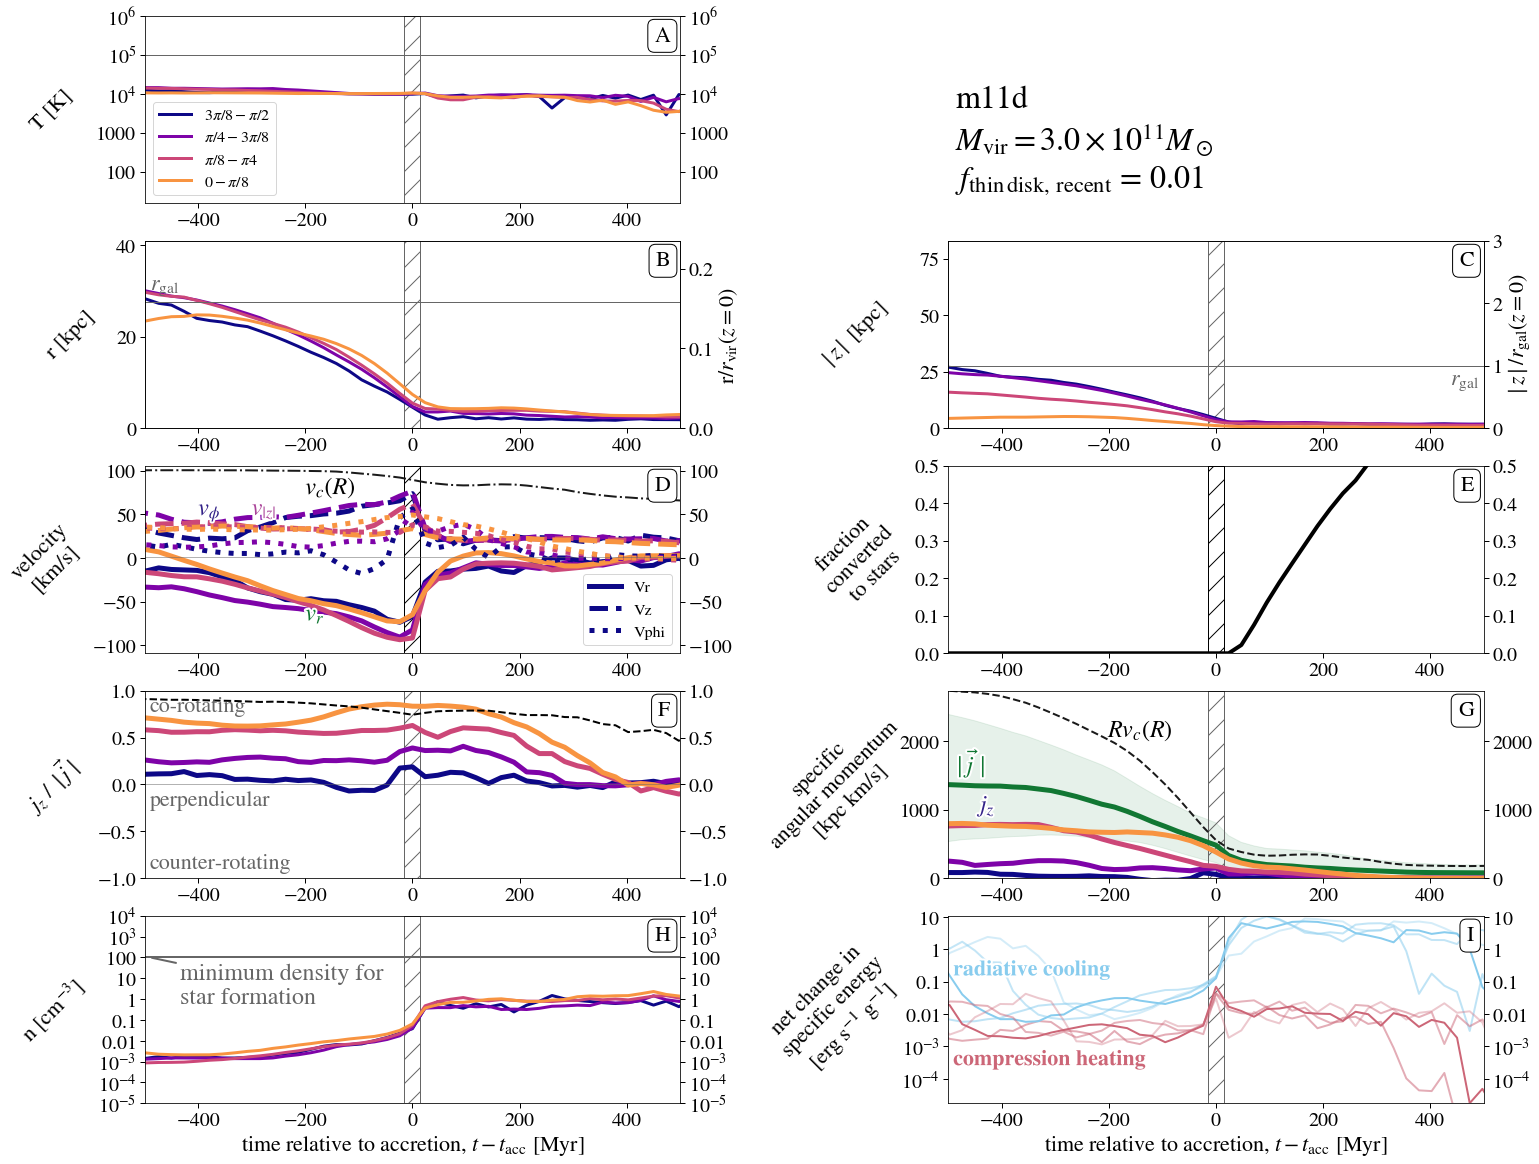

In [167]:
fig

In [168]:
# Move the time offset back
time += time_offset